# <center> 14MBID .- Trabajo de Fin de Master <center>
## <center> Desarrollo de un modelo predictivo en base a sintomatología de salud mental que derivan en ansiedad y depresión <center>
###   <center> (Primera Parte .- Analisis de Variables para el año 2014) <center>
### <center> Autor: Ricardo Marrero Carrión <center>

### Indice
<ol>
<li>Librerias a Utilizar y Comprobaciones Iniciales</li>
<li>Funciones del modelo</li>
<li>Introducción</li>
<li>Carga de los Datasets</li>
<li>Limpieza y Preprocesamiento de los Datos I</li>
<li>Limpieza y Preprocesamiento de los Datos II</li>
<li>Limpieza y Preprocesamiento de los Datos III</li> 
<li>Reducción de los datos</li>
<li>Conjunto de Datos para el Análisis Exploratorio</li>
</ol>

### 1.- Librerías a Utilizar y comprobaciones iniciales

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

import warnings
warnings.filterwarnings('ignore')

import missingno as ms

import utilidades as ut

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from feature_selector import FeatureSelector

### 2.- Funciones del Modelo

Las funciones utilizadas en el modelo, son importadas de un fichero .py llamado utilidades.py

### 3.- Introducción

_(Comprensión del Dominio)_

<b>Objetivo:</b> El objetivo del presente proyecto es identificar patrones dentro de un grupo de indicadores o atributos, y su posible relación con la Ansiedad y la Depresión.

<b>Datos:</b> El Conjunto de Datos utilizado en este proyecto se ha recogido en el Instituto Nacional de Estadística (INE), y específicamente en el resultado de la "Encuesta Europea de Salud 2014" [EESE-2014](https://www.ine.es/dyngs/INEbase/operacion.htm?c=Estadistica_C&cid=1254736176784&menu=resultados&idp=1254735573175#!tabs-1254736195298)

Esta encuesta genera dos conjuntos de datos según la fase de la entrevista:
* _Cuestionario del Hogar_: contiene datos generales de la entrevista y permite seleccionar al individuo para desarrolar la encuesta.
* _Cuestionario del Individio_: contiene los datos específicos de la entrevista, y se cumplimentan todos los indicadores sociodemográficos y de salud objeto de la entrevista.

<b>Enfoque:</b> Para ambos cuestionarios se genera un fichero con el diseño de registro de los microdatos; es decir, nos permite identificar a cada variable, su posición y longitud en el conjunto de datos, así como los posible valores que puede tomar cada atributo.

Estos ficheros son: dr_EESEhogar_2014 y dr_EESEadulto_2014

<b>Metodología:</b> La forma en que el conjunto de datos será procesado, seguirá lo indicado en la fases del _Proceso KDD_; donde:
* En una primera iteración sea realizará un estudio de cada grupo de datos, para identificar su comportamiento, y así poder realizar una limpieza y homogeneización de los mismos.
* Posteriormente se realizará un proceso de transformación donde se escojan los indicadores significativos para eñ desarrollo del modelo
* Por último se realizará un análisis exploratorio y de minería de datos, para identificar correlaciones y escoger el/los modelos que mejor se adapten al objetivo planteado

### 4.- Carga de los Datasets

_(Creación del Conjunto de Datos)_

In [2]:
#Insertar comentario del dataset
adulto2014 = pd.read_csv('EESEadulto_2014.csv', sep='\s+')

In [3]:
#Insertar comentario del dataset
hogar2014 = pd.read_csv('EESEhogar_2014.csv', sep='\s+')

Realizamos una inspección de ambos dataframes

In [4]:
adulto2014.head()

,CCAA,IDENTHOGAR,A7_2a,SEXOa,EDADa,PROXY_0,PROXY_1,PROXY_2,PROXY_2b,PROXY_3b,...,Y134,Y135,FACTORADULTO,CLASE_PR,IMC,SINTOMATOLOGIA_DEPRESIVA,CUADROS_DEPRESIVOS,CMD1,CMD2,CMD3
0,16,1021,1,2,81,2,2,2,,2,...,,,761.414,9,3,4,1,10.00,10.0,10.00
1,16,1031,1,1,38,1,,,,,...,1,3,1723.096,3,4,1,3,11.43,0.0,26.67
2,16,1041,1,1,63,1,,,,,...,,,1890.626,1,2,1,3,5.71,0.0,13.33
3,16,1071,1,1,69,1,,,,,...,,,1490.354,2,3,1,2,122.86,125.0,120.00
4,16,1101,1,2,48,1,,,,,...,,,1253.550,1,2,1,3,7.14,0.0,16.67


In [5]:
hogar2014.head()

,CCAA,IDENTHOGAR,ESTRATO,SEXO_i,EDAD_i,NORDEN_Ai,NORDEN_Mi,NADULTOS,NMENORES,A7_1_i,...,D23_4,D23_5,D23_6,D23_7,D23_8,D23_9,D23_10,D23_11,D24,D26
0,16,1021,1,2,81,01,,1,0,1,...,2,2,2,2,2,2,2,2,,2
1,16,1031,1,1,38,01,,2,1,2,...,2,2,2,2,1,2,2,2,1,5
2,16,1031,1,2,38,02,,2,1,1,...,,,,,,,,,,99
3,16,1031,1,1,1,,51,2,1,2,...,,,,,,,,,,99
4,16,1041,1,1,63,01,,3,0,2,...,2,2,2,2,2,2,2,2,,5


### 5.- Limpieza y Preprocesamiento de los Datos I

Para facilitar el análisis vamos a eliminar las columna o atributos de la Encuesta de Salud, que se considera no tienen relación en el modelo que se desea generar.

Principalmente son datos de codificación de la encuesta,o datos que pueden ser sustentados por otras preguntas de la encuesta.

Entre los dos datasets a utilzar hay __474 atributos__

In [6]:
print(adulto2014.shape)
print(hogar2014.shape)

(22842, 428)
(56654, 46)


In [7]:
#Listado de atributos a eliminar en el dataframe hogar2014
drop_hogar = ['NORDEN_Ai','NORDEN_Mi','NADULTOS','NMENORES','A7_1_i','NORDEN_Pref','A7_2','A8_1_i','A8_2_i',
              'NORINF','A9_otra','D24','CLASE_PR']

In [8]:
#Listado de atributos a eliminar en el dataframe adulto2014
drop_adulto = ['A7_2a','PROXY_0','PROXY_1','PROXY_2','PROXY_2b','PROXY_3b','PROXY_4','PROXY_5','W128Cer',
              'W128Cer_1','W128Cer_2','W128Cer_3','W128Cer_4','W128Cer_5','W128Cer_6','W128Cer_7','W128Vin',
              'W128Vin_1','W128Vin_2','W128Vin_3','W128Vin_4','W128Vin_5','W128Vin_6','W128Vin_7','W128Vermut',
              'W128Vermut_1','W128Vermut_2','W128Vermut_3','W128Vermut_4','W128Vermut_5','W128Vermut_6',
              'W128Vermut_7','W128Lic','W128Lic_1','W128Lic_2','W128Lic_3','W128Lic_4','W128Lic_5','W128Lic_6',
              'W128Lic_7','W128Comb','W128Comb_1','W128Comb_2','W128Comb_3','W128Comb_4','W128Comb_5','W128Comb_6',
              'W128Comb_7','W128Sidra','W128Sidra_1','W128Sidra_2','W128Sidra_3','W128Sidra_4','W128Sidra_5',
              'W128Sidra_6','W128Sidra_7','CMD1','CMD2','CMD3','N63_1','N63_2','N63_3','N63_4','N63_5','N63_6',
              'N63_7','N63_8','N63_9','N63_10','N64','N65_1','N65_2','N65_3','N65_4','N65_5','N65_6','N65_7',
               'N65_8','I28_1','I28_2','I29_1','I29_2','N55_1','N55_2','N55_3','N56_1','N56_2','N56_3','N58_4',
              'O70','O72','O73','O77','Q97','Q102','Q105','V122','V125']

In [9]:
hogar2014.drop(drop_hogar,axis='columns',inplace=True)
adulto2014.drop(drop_adulto,axis='columns',inplace=True)

En este mismo sentido, se detectan atributos duplicados entre ambas encuestas, por lo que procedemos a borrar una de ellas

In [10]:
drop_hogar2 = ['CCAA','SEXO_i','EDAD_i','A10_i']
hogar2014.drop(drop_hogar2,axis='columns',inplace=True)

In [11]:
print(adulto2014.shape)
print(hogar2014.shape)

(22842, 330)
(56654, 29)


Se han descartado 95 atributos, aún así; no es muy eficiente su tratamiento, por lo que vamos a analizarlo, mediante subsets dependiendo del módulo de la encuesta.

#### 5.1 - Encuesta del Hogar

En primer lugar vamos a seleccionar un atributo indice para identificar a cada registro, para ello utilizaremos el valor de IDENTHOGAR.

En el caso del dataset hogar, este atributo esta duplicado, si en el hogar habían varias personas; pero como solo uno contesta a la encuesta, podremos dejar un solo registro por hogar

In [12]:
hogar2014.sort_values('D23_1',ascending=False,inplace=True)
hogar2014.drop_duplicates('IDENTHOGAR',keep='first',inplace=True)
hogar2014 = hogar2014.set_index('IDENTHOGAR')
hogar2014.sort_values('IDENTHOGAR',inplace=True)

#### 5.2 - Encuesta del Individuo

Igualmente usaremos el atributo IDENTHOGAR como índice del Dataframe; en este caso si existen registros únicos

In [13]:
adulto2014 = adulto2014.set_index('IDENTHOGAR')
adulto2014.sort_values('IDENTHOGAR',inplace=True)

In [14]:
print(adulto2014.shape)
print(hogar2014.shape)

(22842, 329)
(22842, 28)


Y realizamos una primera exportación del dataset; como punto de control para pasar ahora a un segundo nivel de análisis en detalle

In [15]:
adulto2014.to_csv(r'adulto2014_1.csv')
hogar2014.to_csv(r'hogar2014_1.csv')

### 6.- Limpieza y Preprocesamiento de los Datos II

#### 6.1 - Encuesta del Hogar

Cada dataset tiene un enorme número de tributos, para realizar un análisis detallado de sus componentes; vamos a crear una serie de subsets dependiendo de area de conocimiento y según el fichero del diseño de regsitro de los microdatos

In [16]:
#Datos generales del hogar del encuestado
hogar2014_general = hogar2014[['ESTRATO','A11_i','A12','FACTORHOGAR']]

In [17]:
#Datos laborales del encuestado
hogar_2014_datos_persona = hogar2014[['B13','B14','B15_2','B16_2','B17','B18','B19a_2','B19b_2','B20a_2','B20b_2',
                                      'B21a','B21b']]

In [18]:
#Datos de tipo de ingresos del encuestado
hogar_2014_datos_ingresos = hogar2014[['D23_1','D23_2','D23_3','D23_4','D23_5','D23_6','D23_7','D23_8','D23_9',
                                       'D23_10','D23_11','D26']]

Para el subset hogar2020_general, no realizamos ninguna transformación

##### 6.1.1- Subset Datos Personas

In [19]:
#El tipo de los datos ha sido cargado en pandas como "object", por lo que hacemos un casting a enteros
hogar_2014_datos_persona.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B13     22842 non-null  object
 1   B14     22842 non-null  object
 2   B15_2   22842 non-null  object
 3   B16_2   22842 non-null  object
 4   B17     22842 non-null  object
 5   B18     22842 non-null  object
 6   B19a_2  22842 non-null  object
 7   B19b_2  22842 non-null  object
 8   B20a_2  22842 non-null  object
 9   B20b_2  22842 non-null  object
 10  B21a    22842 non-null  object
 11  B21b    22842 non-null  object
dtypes: object(12)
memory usage: 2.3+ MB


In [20]:
for col in hogar_2014_datos_persona.columns:
    tipo_columna = hogar_2014_datos_persona[col].dtype
    if tipo_columna == 'O':
        hogar_2014_datos_persona[col] = pd.to_numeric(hogar_2014_datos_persona[col],
                                                            errors='coerce').astype('Int64')

In [21]:
for col in hogar_2014_datos_persona.columns:
    pct_missing = np.mean(hogar_2014_datos_persona[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

B13 - 88%
B14 - 100%
B15_2 - 99%
B16_2 - 99%
B17 - 99%
B18 - 96%
B19a_2 - 77%
B19b_2 - 85%
B20a_2 - 77%
B20b_2 - 85%
B21a - 77%
B21b - 85%


Se observa que estos atributos tienen un alto porcentaje de missing_values; es decir, no fueron contestados por los encuestados. Por lo que descartamos su uso.

Atributos similares, se encuentran en la encuesta individual

##### 6.1.2 - Subset Datos Ingresos

In [22]:
hogar_2014_datos_ingresos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   D23_1   22842 non-null  object
 1   D23_2   22842 non-null  object
 2   D23_3   22842 non-null  object
 3   D23_4   22842 non-null  object
 4   D23_5   22842 non-null  object
 5   D23_6   22842 non-null  object
 6   D23_7   22842 non-null  object
 7   D23_8   22842 non-null  object
 8   D23_9   22842 non-null  object
 9   D23_10  22842 non-null  object
 10  D23_11  22842 non-null  object
 11  D26     22842 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 2.3+ MB


In [23]:
for col in hogar_2014_datos_ingresos.columns:
    tipo_columna = hogar_2014_datos_ingresos[col].dtype
    if tipo_columna == 'O':
        hogar_2014_datos_ingresos[col] = pd.to_numeric(hogar_2014_datos_ingresos[col],
                                                            errors='coerce').astype('Int64')

In [24]:
for col in hogar_2014_datos_ingresos.columns:
    pct_missing = np.mean(hogar_2014_datos_ingresos[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

D23_1 - 0%
D23_2 - 0%
D23_3 - 0%
D23_4 - 0%
D23_5 - 0%
D23_6 - 0%
D23_7 - 0%
D23_8 - 0%
D23_9 - 0%
D23_10 - 0%
D23_11 - 0%
D26 - 0%


En este caso hay ausencia de valores nulos

Cada uno de estos atributos representa un tipo de ingreso del encuestado; por lo que no eliminamos ni transformamos ninguna de las variables.

Por lo tanto los atributos a utilizar de la encuesta de hogar seran los siguientes:

In [25]:
df_hogar = pd.concat([hogar2014_general,hogar_2014_datos_ingresos],axis=1)

In [26]:
df_hogar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ESTRATO      22842 non-null  int64  
 1   A11_i        22842 non-null  int64  
 2   A12          22842 non-null  int64  
 3   FACTORHOGAR  22842 non-null  float64
 4   D23_1        22842 non-null  Int64  
 5   D23_2        22842 non-null  Int64  
 6   D23_3        22842 non-null  Int64  
 7   D23_4        22842 non-null  Int64  
 8   D23_5        22842 non-null  Int64  
 9   D23_6        22842 non-null  Int64  
 10  D23_7        22842 non-null  Int64  
 11  D23_8        22842 non-null  Int64  
 12  D23_9        22842 non-null  Int64  
 13  D23_10       22842 non-null  Int64  
 14  D23_11       22842 non-null  Int64  
 15  D26          22842 non-null  int64  
dtypes: Int64(11), float64(1), int64(4)
memory usage: 3.2 MB


#### 6.2 - Encuesta del Individuo

Tal y como se realizó con el dataset del hogar, procedemos a subdividir según área de conocimiento y siguiendo el fichero de registro de los microdatos, para un mesjor análisis

In [28]:
#Datos asociados con el objetivo del estudio (ansiedad y depresión)
adulto2014_target = adulto2014[['G25a_20','G25b_20','G25c_20','G25a_21','G25b_21','G25c_21',
                                'SINTOMATOLOGIA_DEPRESIVA','CUADROS_DEPRESIVOS']]

In [29]:
#Datos generales del individuo encuestado
adulto2014_general = adulto2014[['CCAA','SEXOa','EDADa','E1_1','E2_1a','E2_1b','E2_1c','E2_1d','E3','E4',
                                 'E4b','ESTUDIOS','S109','S110','FACTORADULTO','CLASE_PR','IMC']]

In [30]:
#Datos Socioeconomicos
adulto2014_socioeconomico = adulto2014[['F6','F7','F8_2','F9_2','F10','F11','F12','F13','F14a','F14b','F15','F16',
                                        'F17','F18a_2','F18b_2','F19a_2','F19b_2','F20','J30','J31']]

In [32]:
#Datos Determinantes de la Salud
adulto2014_DeterminantesSalud = adulto2014[['R106','R107','R108_1','R108_2','R108_3','R108_4','T111','T112',
                                      'T113','T114','T115','T116','T117','T118_1','T118_2','T119','U120_1','U120_1a','U120_2','U120_3','U120_4','U120_5','U120_6',
                                      'U120_7','U120_7a','U120_8','U120_9','U120_10','U120_11','U120_12','U120_13',
                                      'U120_14','U120_15','U120_15a','U120FZ','U120CANTFZ','V121','V123','V124',
                                      'V126','W127','W129','X130','X131', 'X132','Y133','Y134','Y135']]

In [34]:
#Datos del Estado de la Salud del Individuo
adulto2014_EstadoSalud = adulto2014[['G21','G22','G23','G24','G25a_1','G25b_1','G25c_1','G25a_2','G25b_2',
                                     'G25c_2','G25a_3','G25b_3','G25c_3','G25a_4','G25b_4','G25c_4',
                                     'G25a_5','G25b_5','G25c_5','G25a_6','G25b_6','G25c_6','G25a_7','G25b_7',
                                     'G25c_7','G25a_8','G25b_8','G25c_8','G25a_9','G25b_9','G25c_9','G25a_10',
                                     'G25b_10','G25c_10','G25a_11','G25b_11','G25c_11','G25a_12','G25b_12',
                                     'G25c_12','G25a_13','G25b_13','G25c_13','G25a_14','G25b_14','G25c_14',
                                     'G25a_15','G25b_15','G25c_15','G25a_16','G25b_16','G25c_16','G25a_17',
                                     'G25b_17','G25c_17','G25a_18','G25b_18','G25c_18','G25a_19','G25b_19',
                                     'G25c_19','G25a_22','G25b_22','G25c_22','G25a_23','G25b_23','G25c_23',
                                     'G25a_24','G25b_24','G25c_24','G25a_25','G25b_25','G25c_25',
                                     'G25a_26','G25b_26','G25c_26','G25a_27','G25b_27','G25c_27','G25a_28',
                                     'G25b_28','G25c_28','G25a_29','G25b_29','G25c_29','G25a_30','G25b_30',
                                     'G25c_30','G25a_31','G25b_31','G25c_31','G25a_32','G25b_32','G25c_32',
                                     'H26_1','H26_2','H26_3','H27','K32','K33','K34','K35','K36','K37','K38',
                                     'L39_1','L39_2','L39_3','L39_4','L39_5','L40','L41','L42_1',
                                     'L42_2','L42_3','L42_4','L42_5','L42_6','L42_7','L43','L44','L45','L46']]

In [36]:
#Datos sobre la Asistencia Sanitaria
adulto2014_AsistenciaSanitaria = adulto2014[['N48','N49','N50','N51','N52','N53','N54','N57','N58_1','N58_2',
                                             'N58_3','N59','N60_1','N60_2','N60_3','N60_4',
                                             'N61_1','N61_2','N61_3','N61_4','N61_5','N62',
                                             'O66','O67','O68','O69','O71','O74','O75','O76','O78','O79',
                                             'O80_1','O80_2','O80_3','O81_1','O81_2','O81_3','O82_1','O82_2','O83',
                                             'O84_1','O84_2','O84_3','O84_4','O84_5','O84_6','O84_7','O84_8',
                                             'O84_9','P85','P86','P87_1a','P87_1b','P87_2a','P87_2b','P87_3a',
                                             'P87_3b','P87_4a','P87_4b','P87_5a','P87_5b','P87_6a','P87_6b',
                                             'P87_7a','P87_7b','P87_8a','P87_8b','P87_9a','P87_9b','P87_10a',
                                             'P87_10b','P87_11a','P87_11b','P87_12a','P87_12b','P87_13a',
                                             'P87_13b','P87_14a','P87_14b','P87_15a','P87_15b','P87_16a','P87_16b',
                                             'P87_17a','P87_17b','P87_18a','P87_18b','P87_19a','P87_19b','P87_20a',
                                             'P87_20b','P87_21a','P87_21b','P87_22a','P87_22b','P87_23a','P87_23b',
                                             'Q88','Q89','Q90','Q91','Q92','Q93','Q94','Q95','Q96','Q98','Q99',
                                             'Q100','Q101','Q103','Q104']]

##### 6.2.1 - Subset Target

In [37]:
adulto2014_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   G25a_20                   22842 non-null  int64 
 1   G25b_20                   22842 non-null  object
 2   G25c_20                   22842 non-null  object
 3   G25a_21                   22842 non-null  int64 
 4   G25b_21                   22842 non-null  object
 5   G25c_21                   22842 non-null  object
 6   SINTOMATOLOGIA_DEPRESIVA  22842 non-null  int64 
 7   CUADROS_DEPRESIVOS        22842 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 1.6+ MB


El subset tiene 8 atributos, relacionados con haber haber padecido Ansiedad o Depresion.

Los atributos G25c_20 (Depresión) y G25c_21(Ansiedad), indican si han sido diagnosticados por un médico.

Usaremos estos entonces, como la CLASE del dataset

In [38]:
for col in adulto2014_target.columns:
    tipo_columna = adulto2014_target[col].dtype
    if tipo_columna == 'O':
        adulto2014_target[col] = pd.to_numeric(adulto2014_target[col],
                                                            errors='coerce').astype('Int64')

In [39]:
for col in adulto2014_target.columns:
    pct_missing = np.mean(adulto2014_target[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

G25a_20 - 0%
G25b_20 - 88%
G25c_20 - 88%
G25a_21 - 0%
G25b_21 - 90%
G25c_21 - 90%
SINTOMATOLOGIA_DEPRESIVA - 0%
CUADROS_DEPRESIVOS - 0%


Debemos cambiar los atributos TARGET, debido a que se oberva un alto porcentaje de missings en si las enfermedades han sido diagnosticadas por un médico.

Por lo tanto cambiamos nuestros valores TARGET a: G25a_20 (Depresión) y G25a_21(Ansiedad)

Que por cierto, no hay valores missing en dichas respuestas

Cambiamos el nombre de dichas columnas, para ir identificando nuestro target, y hacemos un nuevo subset que añadiremos al finel del dataframe final.

In [40]:
df_clase = adulto2014_target[['G25a_20','G25a_21']]
df_clase.columns = ['DEPRESION','ANSIEDAD']

In [41]:
#Funciones creadas en utilidades.py
ut.val_counts(df_clase)

DEPRESION value counts 



2    20122
1     2703
8       12
9        5
Name: DEPRESION, dtype: int64

************************************
ANSIEDAD value counts 



2    20642
1     2184
8       11
9        5
Name: ANSIEDAD, dtype: int64

************************************


Se observa que hay un pequeño número de registros que toman los valores de NO SABE (8) o NO CONTESTA (9).

Como representan un porcentaje muy bajo sobre el total de registros, se procede a agruparlos con la no presencia de la enfermedad (2), para no alterar la muestra de SI presencia de la enfermedad.

In [42]:
target_col = ['DEPRESION','ANSIEDAD']

In [43]:
for col in target_col:
    df_clase[col].replace({8 : 2, 
                           9 : 2},inplace=True)

Seguiremos usando los atributos G25b_x, ya que nos ayudarána. determinar si dichas enfermedades han estado presente en los últimos 12 meses; igualmente seguiremos usando por ahora, las variables derivadas SEVERIDAD_DEPRESIVA y CUADROS_DEPRESIVOS.

Igualmente con los atributos G25c_x; ya que en caso de haber presentado la enfermedad, nos dirá si fue diagnosticada por un medico

In [45]:
df_otros_clase = adulto2014_target[['G25b_20','G25c_20','G25b_21','G25c_21','SINTOMATOLOGIA_DEPRESIVA',
                                    'CUADROS_DEPRESIVOS']]

##### 6.2.2 - Subset General

In [46]:
adulto2014_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CCAA          22842 non-null  int64  
 1   SEXOa         22842 non-null  int64  
 2   EDADa         22842 non-null  int64  
 3   E1_1          22842 non-null  int64  
 4   E2_1a         22842 non-null  int64  
 5   E2_1b         22842 non-null  int64  
 6   E2_1c         22842 non-null  int64  
 7   E2_1d         22842 non-null  int64  
 8   E3            1937 non-null   float64
 9   E4            22842 non-null  int64  
 10  E4b           22842 non-null  int64  
 11  ESTUDIOS      22842 non-null  int64  
 12  S109          22842 non-null  int64  
 13  S110          22842 non-null  int64  
 14  FACTORADULTO  22842 non-null  float64
 15  CLASE_PR      22842 non-null  int64  
 16  IMC           22842 non-null  int64  
dtypes: float64(2), int64(15)
memory usage: 3.1 MB


In [47]:
for col in adulto2014_general.columns:
    pct_missing = np.mean(adulto2014_general[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

CCAA - 0%
SEXOa - 0%
EDADa - 0%
E1_1 - 0%
E2_1a - 0%
E2_1b - 0%
E2_1c - 0%
E2_1d - 0%
E3 - 92%
E4 - 0%
E4b - 0%
ESTUDIOS - 0%
S109 - 0%
S110 - 0%
FACTORADULTO - 0%
CLASE_PR - 0%
IMC - 0%


In [48]:
#Funciones creadas en utilidades.py
ut.val_counts(adulto2014_general)

CCAA value counts 



1     2606
13    2451
9     2342
10    1795
12    1342
7     1323
16    1264
8     1111
5     1097
2     1052
14    1013
11     964
3      867
15     836
6      815
4      813
17     691
19     274
18     186
Name: CCAA, dtype: int64

************************************
SEXOa value counts 



2    12294
1    10548
Name: SEXOa, dtype: int64

************************************
EDADa value counts 



42     499
39     493
40     489
41     461
44     455
      ... 
98      11
97       7
96       7
99       5
102      1
Name: EDADa, Length: 86, dtype: int64

************************************
E1_1 value counts 



1    20905
2     1937
Name: E1_1, dtype: int64

************************************
E2_1a value counts 



1    21550
2     1292
Name: E2_1a, dtype: int64

************************************
E2_1b value counts 



2    21090
1     1752
Name: E2_1b, dtype: int64

************************************
E2_1c value counts 



2    22841
1        1
Name: E2_1c, dtype: int64

************************************
E2_1d value counts 



2    22841
1        1
Name: E2_1d, dtype: int64

************************************
E3 value counts 



NaN     20905
10.0      162
14.0      151
8.0       132
12.0      127
        ...  
77.0        1
67.0        1
55.0        1
75.0        1
61.0        1
Name: E3, Length: 72, dtype: int64

************************************
E4 value counts 



1    11722
3    10241
2      762
9      111
8        6
Name: E4, dtype: int64

************************************
E4b value counts 



2    12322
1     5960
3     2939
5     1034
4      565
9       19
8        3
Name: E4b, dtype: int64

************************************
ESTUDIOS value counts 



4    5194
5    4608
9    4260
6    2693
3    2512
8    1691
7    1484
2     400
Name: ESTUDIOS, dtype: int64

************************************
S109 value counts 



160    2039
170    1792
165    1738
175     945
168     897
       ... 
138       2
116       2
134       1
137       1
120       1
Name: S109, Length: 70, dtype: int64

************************************
S110 value counts 



70     1332
80     1254
60     1030
65      929
75      893
       ... 
160       1
180       1
167       1
136       1
30        1
Name: S110, Length: 107, dtype: int64

************************************
FACTORADULTO value counts 



1086.737    122
2173.474     86
2018.299     70
661.586      54
1133.906     53
           ... 
4171.284      1
3378.427      1
1423.776      1
1405.167      1
357.196       1
Name: FACTORADULTO, Length: 6689, dtype: int64

************************************
CLASE_PR value counts 



5    7295
3    4262
4    3285
6    3101
1    2479
2    1881
9     539
Name: CLASE_PR, dtype: int64

************************************
IMC value counts 



2    9635
3    8018
4    3702
9    1056
1     431
Name: IMC, dtype: int64

************************************


Del análisis de valores missing y tendencia en las respuestas, podemos descartar los siguientes atributos:
* E3 -> 91% de Missing Values
* E2_1c -> Tiene una sola tendencia de respuesta (NO)
* E2_1d -> Tiene una sola tendencia de respuesta (NO)

Por lo tanto, el subset de caracteristicas generales, queda de la siguiente forma:

In [49]:
df_generales = adulto2014_general[['CCAA','SEXOa','EDADa','E1_1','E2_1a','E2_1b','E4','E4b','ESTUDIOS',
                                   'S109','S110','FACTORADULTO','CLASE_PR','IMC']]

##### 6.2.3 - Subset Socioeconómico

In [50]:
adulto2014_socioeconomico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F6      22842 non-null  object 
 1   F7      22842 non-null  object 
 2   F8_2    22842 non-null  object 
 3   F9_2    22842 non-null  object 
 4   F10     22842 non-null  object 
 5   F11     22842 non-null  object 
 6   F12     22842 non-null  object 
 7   F13     22842 non-null  object 
 8   F14a    22842 non-null  object 
 9   F14b    22842 non-null  object 
 10  F15     22842 non-null  object 
 11  F16     22842 non-null  object 
 12  F17     22842 non-null  object 
 13  F18a_2  22842 non-null  object 
 14  F18b_2  22842 non-null  object 
 15  F19a_2  22842 non-null  object 
 16  F19b_2  22842 non-null  object 
 17  F20     22842 non-null  object 
 18  J30     22842 non-null  object 
 19  J31     2108 non-null   float64
dtypes: float64(1), object(19)
memory usage: 3.7+ MB


In [51]:
for col in adulto2014_socioeconomico.columns:
    tipo_columna = adulto2014_socioeconomico[col].dtype
    if tipo_columna == 'O':
        adulto2014_socioeconomico[col] = pd.to_numeric(adulto2014_socioeconomico[col],
                                                            errors='coerce').astype('Int64')

In [52]:
for col in adulto2014_socioeconomico.columns:
    pct_missing = np.mean(adulto2014_socioeconomico[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

F6 - 70%
F7 - 98%
F8_2 - 93%
F9_2 - 93%
F10 - 93%
F11 - 87%
F12 - 86%
F13 - 57%
F14a - 94%
F14b - 100%
F15 - 57%
F16 - 57%
F17 - 57%
F18a_2 - 57%
F18b_2 - 59%
F19a_2 - 57%
F19b_2 - 59%
F20 - 59%
J30 - 57%
J31 - 91%


Al igual que ocurrió en la encuesta del hogar (subset datos de actividad economica), existe un alto porcentaje de valores missing; por lo tanto, procedemos a descatar igualmente este nivel de detalle del estado laboral del encuestado, y dejamos como valor de referencia el atributo A11_i (Situación laboral actual) de la encuesta del hogar.

Pero mantenemos el atributo J30, por estudiar si el individuo ha estado de baja laboral al último año


Igualmente, a pesar que tiene aproximadamente al mitad de los registros no posee información de la actividad de la empresa y ocupación, seguiremos utilizando las variables F18a_2, F19a_2 y F20, por si en una correlación futura hay relación con la presencia de deprsión o ansiedad

In [53]:
df_economico = adulto2014_socioeconomico[['F18a_2','F19a_2','F20','J30']]

##### 6.2.4 - Subset Determinantes de la Salud

In [54]:
adulto2014_DeterminantesSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 48 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   R106        22842 non-null  int64  
 1   R107        22842 non-null  int64  
 2   R108_1      22842 non-null  int64  
 3   R108_2      22842 non-null  int64  
 4   R108_3      22842 non-null  int64  
 5   R108_4      22842 non-null  int64  
 6   T111        22842 non-null  int64  
 7   T112        22842 non-null  int64  
 8   T113        22842 non-null  int64  
 9   T114        22842 non-null  object 
 10  T115        22842 non-null  int64  
 11  T116        22842 non-null  object 
 12  T117        22842 non-null  int64  
 13  T118_1      9773 non-null   float64
 14  T118_2      9773 non-null   float64
 15  T119        22842 non-null  int64  
 16  U120_1      22842 non-null  int64  
 17  U120_1a     15068 non-null  float64
 18  U120_2      22842 non-null  int64  
 19  U120_3      22842 no

In [55]:
for col in adulto2014_DeterminantesSalud.columns:
    tipo_columna = adulto2014_DeterminantesSalud[col].dtype
    if tipo_columna == 'O':
        adulto2014_DeterminantesSalud[col] = pd.to_numeric(adulto2014_DeterminantesSalud[col],
                                                            errors='coerce').astype('Int64')

In [56]:
for col in adulto2014_DeterminantesSalud.columns:
    pct_missing = np.mean(adulto2014_DeterminantesSalud[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

R106 - 0%
R107 - 0%
R108_1 - 0%
R108_2 - 0%
R108_3 - 0%
R108_4 - 0%
T111 - 0%
T112 - 0%
T113 - 0%
T114 - 20%
T115 - 0%
T116 - 91%
T117 - 0%
T118_1 - 57%
T118_2 - 57%
T119 - 0%
U120_1 - 0%
U120_1a - 34%
U120_2 - 0%
U120_3 - 0%
U120_4 - 0%
U120_5 - 0%
U120_6 - 0%
U120_7 - 0%
U120_7a - 55%
U120_8 - 0%
U120_9 - 0%
U120_10 - 0%
U120_11 - 0%
U120_12 - 0%
U120_13 - 0%
U120_14 - 0%
U120_15 - 0%
U120_15a - 86%
U120FZ - 99%
U120CANTFZ - 99%
V121 - 0%
V123 - 79%
V124 - 78%
V126 - 0%
W127 - 0%
W129 - 34%
X130 - 0%
X131 - 0%
X132 - 0%
Y133 - 0%
Y134 - 89%
Y135 - 89%


In [57]:
# las preguntas Rxxx, estan relacionadas con atención médica no cubierta, crearemos un nuevo atributo resumen
#donde se indique SI (1) o NO (2) el encuestado se a visto afectado por este supuesto
adulto2014_DeterminantesSalud['R_Sum'] = np.where((adulto2014_DeterminantesSalud['R106'] == 1) | 
                                                   (adulto2014_DeterminantesSalud['R107'] == 1) |
                                                   (adulto2014_DeterminantesSalud['R108_1'] == 1) |
                                                   (adulto2014_DeterminantesSalud['R108_2'] == 1) |
                                                   (adulto2014_DeterminantesSalud['R108_3'] == 1) |
                                                   (adulto2014_DeterminantesSalud['R108_4'] == 1),1,2)

In [58]:
#Eliminamos columnas sumarizadas
adulto2014_DeterminantesSalud.drop(['R106','R107','R108_1','R108_2','R108_3','R108_3','R108_4'],
                                   axis=1,inplace=True)

In [61]:
# En lo relacionado con la actividad física, vamos a quedarnos solo con los atributos que determinan, que tipo
#de actividad se hace en el trabajo, y con que frecuencia se hace actividad física en el tiempo libre
adulto2014_DeterminantesSalud.drop(['T113','T114','T115','T116','T117','T118_1','T118_2','T119']
                                   ,axis=1,inplace=True)

In [63]:
# Unificamos mediante un promedio, los atributos relacionados con el consumo de fruta
adulto2014_DeterminantesSalud['U_fruta_Avg'] = (adulto2014_DeterminantesSalud.U120_1 +
adulto2014_DeterminantesSalud.U120_15)/2
adulto2014_DeterminantesSalud['U_fruta_Avg'] = adulto2014_DeterminantesSalud['U_fruta_Avg'].astype(int)
adulto2014_DeterminantesSalud.drop(['U120_1','U120_15'],axis=1,inplace=True)

In [64]:
# Realizamos la misma transformación para otras otras variables de consumo de alimentos
#Alimentos Ultraprocesados
adulto2014_DeterminantesSalud['U_NoFood_Avg'] = (adulto2014_DeterminantesSalud.U120_9 +
adulto2014_DeterminantesSalud.U120_11 + adulto2014_DeterminantesSalud.U120_12 +
adulto2014_DeterminantesSalud.U120_13 + adulto2014_DeterminantesSalud.U120_14)/5
adulto2014_DeterminantesSalud['U_NoFood_Avg'] = adulto2014_DeterminantesSalud['U_NoFood_Avg'].astype(int)
adulto2014_DeterminantesSalud.drop(['U120_9','U120_11','U120_12','U120_13','U120_14'],axis=1,inplace=True)

In [65]:
#Alimentos Huevos y Lacteos
adulto2014_DeterminantesSalud['U_HuLac_Avg'] = (adulto2014_DeterminantesSalud.U120_3 +
adulto2014_DeterminantesSalud.U120_10)/2
adulto2014_DeterminantesSalud['U_HuLac_Avg'] = adulto2014_DeterminantesSalud['U_HuLac_Avg'].astype(int)
adulto2014_DeterminantesSalud.drop(['U120_3','U120_10'],axis=1,inplace=True)

In [66]:
#Alimentos Carbohidratos
adulto2014_DeterminantesSalud['U_Carb_Avg'] = (adulto2014_DeterminantesSalud.U120_5 +
adulto2014_DeterminantesSalud.U120_6)/2
adulto2014_DeterminantesSalud['U_Carb_Avg'] = adulto2014_DeterminantesSalud['U_Carb_Avg'].astype(int)
adulto2014_DeterminantesSalud.drop(['U120_5','U120_6'],axis=1,inplace=True)

In [68]:
#Analisis sobre Consumo de Tabaco, solo nos aportaría información si fuma y su frecuencia, por lo que dejamos 
#solo la variable V121
adulto2014_DeterminantesSalud.drop(['V123','V124','V126'],
                                   axis=1,inplace=True)

In [69]:
#Analisis de consumo de alcohol, igualmente nos quedamos solo con la frecuencia de consumo W127
adulto2014_DeterminantesSalud.drop('W129',axis=1,inplace=True)

In [70]:
#Analisis de Apoyo Social y Cuidado de Personas
#Descartamos la variable Y134, porque en principio no aporta el parentesco de a quien se cuida.
#La variable Y135, posee un alto porcentaje de missing, pero aporta información de cuantas horas dedica el
#encuestado al cuidado; podemos completarlo con el valor por defecto "No Contesta (9)"
adulto2014_DeterminantesSalud.drop('Y134',axis=1,inplace=True)
adulto2014_DeterminantesSalud['Y135'] = adulto2014_DeterminantesSalud['Y135'].fillna(9)

In [71]:
adulto2014_DeterminantesSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   T111          22842 non-null  int64
 1   T112          22842 non-null  int64
 2   U120_2        22842 non-null  int64
 3   U120_4        22842 non-null  int64
 4   U120_7        22842 non-null  int64
 5   U120_8        22842 non-null  int64
 6   V121          22842 non-null  int64
 7   W127          22842 non-null  int64
 8   X130          22842 non-null  int64
 9   X131          22842 non-null  int64
 10  X132          22842 non-null  int64
 11  Y133          22842 non-null  int64
 12  Y135          22842 non-null  Int64
 13  R_Sum         22842 non-null  int64
 14  U_fruta_Avg   22842 non-null  int64
 15  U_NoFood_Avg  22842 non-null  int64
 16  U_HuLac_Avg   22842 non-null  int64
 17  U_Carb_Avg    22842 non-null  int64
dtypes: Int64(1), int64(17)
memory usage: 3.3 MB


In [72]:
#Para estandarizar los df que luego seran concatentados en el dataset individuos
df_determinante = adulto2014_DeterminantesSalud

##### 6.2.5 - Subset Estado de Salud

In [73]:
adulto2014_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 123 entries, G21 to L46
dtypes: int64(40), object(83)
memory usage: 21.6+ MB


De entrada vemos que como es un alto número de atributos, no observamos el detalle de cada uno de ellos.

Esta situación nos podría servier de partida para hacer un análisis de este dataset buscando reducir su dimensionalidad

In [74]:
for col in adulto2014_EstadoSalud.columns:
    tipo_columna = adulto2014_EstadoSalud[col].dtype
    if tipo_columna == 'O':
        adulto2014_EstadoSalud[col] = pd.to_numeric(adulto2014_EstadoSalud[col],errors='coerce').astype('Int64')

In [75]:
adulto2014_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 123 entries, G21 to L46
dtypes: Int64(83), int64(40)
memory usage: 23.4 MB


In [76]:
for col in adulto2014_EstadoSalud.columns:
    pct_missing = np.mean(adulto2014_EstadoSalud[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

G21 - 0%
G22 - 0%
G23 - 0%
G24 - 71%
G25a_1 - 0%
G25b_1 - 74%
G25c_1 - 74%
G25a_2 - 0%
G25b_2 - 98%
G25c_2 - 98%
G25a_3 - 0%
G25b_3 - 98%
G25c_3 - 98%
G25a_4 - 0%
G25b_4 - 94%
G25c_4 - 94%
G25a_5 - 0%
G25b_5 - 83%
G25c_5 - 83%
G25a_6 - 0%
G25b_6 - 77%
G25c_6 - 77%
G25a_7 - 0%
G25b_7 - 80%
G25c_7 - 80%
G25a_8 - 0%
G25b_8 - 77%
G25c_8 - 77%
G25a_9 - 0%
G25b_9 - 84%
G25c_9 - 84%
G25a_10 - 0%
G25b_10 - 94%
G25c_10 - 94%
G25a_11 - 0%
G25b_11 - 95%
G25c_11 - 95%
G25a_12 - 0%
G25b_12 - 91%
G25c_12 - 91%
G25a_13 - 0%
G25b_13 - 96%
G25c_13 - 96%
G25a_14 - 0%
G25b_14 - 94%
G25c_14 - 94%
G25a_15 - 0%
G25b_15 - 77%
G25c_15 - 77%
G25a_16 - 0%
G25b_16 - 88%
G25c_16 - 88%
G25a_17 - 0%
G25b_17 - 94%
G25c_17 - 94%
G25a_18 - 0%
G25b_18 - 94%
G25c_18 - 94%
G25a_19 - 0%
G25b_19 - 99%
G25c_19 - 99%
G25a_22 - 0%
G25b_22 - 98%
G25c_22 - 98%
G25a_23 - 0%
G25b_23 - 98%
G25c_23 - 98%
G25a_24 - 0%
G25b_24 - 88%
G25c_24 - 88%
G25a_25 - 0%
G25b_25 - 91%
G25c_25 - 91%
G25a_26 - 0%
G25b_26 - 96%
G25c_26 - 96%
G25a_2

Al tener un gran numero de atributos, vamos a ir analizando por seccion

In [77]:
#Accidentalidad (Hx)
#Descartamos H27, porque es un detalle que no aporta en el analisis, y creamos una variable transformada
#agrupando los tipos de accidente
adulto2014_EstadoSalud['H_Sum'] = np.where((adulto2014_EstadoSalud['H26_1'] == 1) | 
                                                   (adulto2014_EstadoSalud['H26_2'] == 1) |
                                                   (adulto2014_EstadoSalud['H26_3'] == 1),1,2)
adulto2014_EstadoSalud.drop(['H26_1','H26_2','H26_3','H27'],axis=1,inplace=True)

In [79]:
#Limitaciones físicas y sensoriales
#Creamos igualmemte una variable transformada que agrupe la existencia de limitaciones físicas y sensoriales
# y mantenemos la variable K38a, que trata sobre la dificultad de concentrarse
adulto2014_EstadoSalud['K_Sum'] = np.where((adulto2014_EstadoSalud['K32'] == 1) | 
                                                   (adulto2014_EstadoSalud['K34'] == 1) |
                                                   (adulto2014_EstadoSalud['K37'] == 1) |
                                                   (adulto2014_EstadoSalud['K38'] == 1),1,2)
adulto2014_EstadoSalud.drop(['K32','K33','K33','K34','K35','K36','K37','K38'],axis=1,inplace=True)

In [80]:
#Limitaciones en la Actividad Diaria
#La mayoria de los atributos contienen un alto porcentaje de missings, en este punto solo eliminaremos los que
#consideramos que no aportan valor o con mas de 90% de missing values
adulto2014_EstadoSalud.drop(['L39_2','L40','L41','L43','L44'],axis=1,inplace=True)

A continuación analizaremos los atributos específicos relacionados con las enfermedades; la encuesta_individuo preguntó sobre 30 tipos distintos.

Para simplificar el estudio procedemos a:
* Borrar si fueron diagnosticadas los últimos 12 meses; es un indicador que solo nos interesa para el caso de la ansiedad y la depresión.
* Crear un atributo que indique si la enfermedad está presente y si fue diagnosticada por un médico

In [82]:
adulto2014_EstadoSalud.drop(['G25b_1','G25b_2','G25b_3','G25b_4','G25b_5','G25b_6','G25b_7','G25b_8','G25b_9',
                            'G25b_10','G25b_11','G25b_12','G25b_13','G25b_14','G25b_15','G25b_16','G25b_17',
                             'G25b_18','G25b_19','G25b_22','G25b_23','G25b_24','G25b_25','G25b_26','G25b_27',
                             'G25b_28','G25b_29','G25b_30','G25b_31','G25b_32']
                            ,axis=1,inplace=True)

In [83]:
diag_col = ['G25c_1','G25c_2','G25c_3','G25c_4','G25c_5','G25c_6','G25c_7','G25c_8','G25c_9','G25c_10','G25c_11',
            'G25c_12','G25c_13','G25c_14','G25c_15','G25c_16','G25c_17','G25c_18','G25c_19','G25c_22','G25c_23',
            'G25c_24','G25c_25','G25c_26','G25c_27','G25c_28','G25c_29','G25c_30','G25c_31','G25c_32']

In [84]:
# Se completan valores nulos con 0 ya que estos son generados cuando no se presenta la enfermedad encuestada
for col in diag_col:
    adulto2014_EstadoSalud[col].fillna(0, inplace=True)

In [85]:
enf_col = ['G25a_1','G25a_2','G25a_3','G25a_4','G25a_5','G25a_6','G25a_7','G25a_8','G25a_9','G25a_10','G25a_11',
            'G25a_12','G25a_13','G25a_14','G25a_15','G25a_16','G25a_17','G25a_18','G25a_19','G25a_22','G25a_23',
            'G25a_24','G25a_25','G25a_26','G25a_27','G25a_28','G25a_29','G25a_30','G25a_31','G25a_32']

In [86]:
#Enfermedades en la prostata y menopauisa, generan null_values según el genero del encuestado; sustituimos por 
#(2) no presenta la enfermedad
for col in enf_col:
    adulto2014_EstadoSalud[col].fillna(2, inplace=True)

Se procede a crear la variable transformada con estas condiciones:
* SI enfermedad & SI diagnosticada = Enfermedad Diagnosticada (1)
* SI enfermedad & NO diagnosticada = Enfermedad No Diagnosticada (3)
* SI enfermedad & NO sabe/NoContesta diagnosticada = Enfermedad No Diagnosticada (3)
* NO enfermedad = No enfermedad (2)

In [87]:
#Funciones creadas en utilidades.py
adulto2014_EstadoSalud['G25_1'] = adulto2014_EstadoSalud.apply(ut.tension_alta, axis=1)
adulto2014_EstadoSalud['G25_2'] = adulto2014_EstadoSalud.apply(ut.infarto, axis=1)
adulto2014_EstadoSalud['G25_3'] = adulto2014_EstadoSalud.apply(ut.angina, axis=1)
adulto2014_EstadoSalud['G25_4'] = adulto2014_EstadoSalud.apply(ut.otros_corazon, axis=1)
adulto2014_EstadoSalud['G25_5'] = adulto2014_EstadoSalud.apply(ut.varices, axis=1)
adulto2014_EstadoSalud['G25_6'] = adulto2014_EstadoSalud.apply(ut.artrosis, axis=1)
adulto2014_EstadoSalud['G25_7'] = adulto2014_EstadoSalud.apply(ut.cervical, axis=1)
adulto2014_EstadoSalud['G25_8'] = adulto2014_EstadoSalud.apply(ut.lumbar, axis=1)
adulto2014_EstadoSalud['G25_9'] = adulto2014_EstadoSalud.apply(ut.alergia, axis=1)
adulto2014_EstadoSalud['G25_10'] = adulto2014_EstadoSalud.apply(ut.asma, axis=1)
adulto2014_EstadoSalud['G25_11'] = adulto2014_EstadoSalud.apply(ut.bronquitis, axis=1)
adulto2014_EstadoSalud['G25_12'] = adulto2014_EstadoSalud.apply(ut.diabetes, axis=1)
adulto2014_EstadoSalud['G25_13'] = adulto2014_EstadoSalud.apply(ut.ulcera, axis=1)
adulto2014_EstadoSalud['G25_14'] = adulto2014_EstadoSalud.apply(ut.urinaria, axis=1)
adulto2014_EstadoSalud['G25_15'] = adulto2014_EstadoSalud.apply(ut.colesterol, axis=1)
adulto2014_EstadoSalud['G25_16'] = adulto2014_EstadoSalud.apply(ut.cataratas, axis=1)
adulto2014_EstadoSalud['G25_17'] = adulto2014_EstadoSalud.apply(ut.dermatitis, axis=1)
adulto2014_EstadoSalud['G25_18'] = adulto2014_EstadoSalud.apply(ut.estrenimiento, axis=1)
adulto2014_EstadoSalud['G25_19'] = adulto2014_EstadoSalud.apply(ut.cirrosis, axis=1)
adulto2014_EstadoSalud['G25_22'] = adulto2014_EstadoSalud.apply(ut.otros_mental, axis=1)
adulto2014_EstadoSalud['G25_23'] = adulto2014_EstadoSalud.apply(ut.ictus, axis=1)
adulto2014_EstadoSalud['G25_24'] = adulto2014_EstadoSalud.apply(ut.migrana, axis=1)
adulto2014_EstadoSalud['G25_25'] = adulto2014_EstadoSalud.apply(ut.hemorroides, axis=1)
adulto2014_EstadoSalud['G25_26'] = adulto2014_EstadoSalud.apply(ut.tumores, axis=1)
adulto2014_EstadoSalud['G25_27'] = adulto2014_EstadoSalud.apply(ut.osteoporosis, axis=1)
adulto2014_EstadoSalud['G25_28'] = adulto2014_EstadoSalud.apply(ut.tiroides, axis=1)
adulto2014_EstadoSalud['G25_29'] = adulto2014_EstadoSalud.apply(ut.rinon, axis=1)
adulto2014_EstadoSalud['G25_30'] = adulto2014_EstadoSalud.apply(ut.prostata, axis=1)
adulto2014_EstadoSalud['G25_31'] = adulto2014_EstadoSalud.apply(ut.meonopausia, axis=1)
adulto2014_EstadoSalud['G25_32'] = adulto2014_EstadoSalud.apply(ut.lesiones, axis=1)

In [88]:
adulto2014_EstadoSalud.drop(diag_col,axis=1,inplace=True)
adulto2014_EstadoSalud.drop(enf_col,axis=1,inplace=True)

In [89]:
adulto2014_EstadoSalud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 49 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   G21     22842 non-null  int64
 1   G22     22842 non-null  int64
 2   G23     22842 non-null  int64
 3   G24     6536 non-null   Int64
 4   L39_1   6520 non-null   Int64
 5   L39_3   6520 non-null   Int64
 6   L39_4   6520 non-null   Int64
 7   L39_5   6520 non-null   Int64
 8   L42_1   6520 non-null   Int64
 9   L42_2   6520 non-null   Int64
 10  L42_3   6520 non-null   Int64
 11  L42_4   6520 non-null   Int64
 12  L42_5   6520 non-null   Int64
 13  L42_6   6520 non-null   Int64
 14  L42_7   6520 non-null   Int64
 15  L45     22842 non-null  int64
 16  L46     22842 non-null  int64
 17  H_Sum   22842 non-null  int64
 18  K_Sum   22842 non-null  int64
 19  G25_1   22842 non-null  int64
 20  G25_2   22842 non-null  int64
 21  G25_3   22842 non-null  int64
 22  G25_4   22842 non-null  int64
 23  G25_5 

In [90]:
#Para estandarizar los df que luego seran concatentados en el dataset individuos
df_estadosalud = adulto2014_EstadoSalud

##### 6.2.6 - Subset Asistencia Sanitaria

In [91]:
adulto2014_AsistenciaSanitaria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 113 entries, N48 to Q104
dtypes: float64(11), int64(35), object(67)
memory usage: 19.9+ MB


In [92]:
for col in adulto2014_AsistenciaSanitaria.columns:
    tipo_columna = adulto2014_AsistenciaSanitaria[col].dtype
    if tipo_columna == 'O':
        adulto2014_AsistenciaSanitaria[col] = pd.to_numeric(adulto2014_AsistenciaSanitaria[col],
                                                            errors='coerce').astype('Int64')

In [93]:
adulto2014_AsistenciaSanitaria.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 113 entries, N48 to Q104
dtypes: Int64(67), float64(11), int64(35)
memory usage: 21.3 MB


In [94]:
#Los atributos 'float64', pueden ser tambien convertidos en enteros, ya que hacen referencia a atributos con
#valores discretos
for col in adulto2014_AsistenciaSanitaria.columns:
    tipo_columna = adulto2014_AsistenciaSanitaria[col].dtype
    if tipo_columna == 'float64':
        adulto2014_AsistenciaSanitaria[col] = pd.to_numeric(adulto2014_AsistenciaSanitaria[col],
                                                            errors='coerce').astype('Int64')

In [95]:
for col in adulto2014_AsistenciaSanitaria.columns:
    pct_missing = np.mean(adulto2014_AsistenciaSanitaria[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

N48 - 0%
N49 - 21%
N50 - 0%
N51 - 43%
N52 - 91%
N53 - 63%
N54 - 63%
N57 - 63%
N58_1 - 0%
N58_2 - 0%
N58_3 - 0%
N59 - 0%
N60_1 - 0%
N60_2 - 0%
N60_3 - 0%
N60_4 - 0%
N61_1 - 0%
N61_2 - 0%
N61_3 - 73%
N61_4 - 0%
N61_5 - 0%
N62 - 0%
O66 - 0%
O67 - 91%
O68 - 91%
O69 - 76%
O71 - 91%
O74 - 91%
O75 - 0%
O76 - 93%
O78 - 0%
O79 - 73%
O80_1 - 73%
O80_2 - 73%
O80_3 - 73%
O81_1 - 73%
O81_2 - 73%
O81_3 - 73%
O82_1 - 73%
O82_2 - 73%
O83 - 73%
O84_1 - 0%
O84_2 - 0%
O84_3 - 0%
O84_4 - 0%
O84_5 - 0%
O84_6 - 0%
O84_7 - 0%
O84_8 - 0%
O84_9 - 0%
P85 - 0%
P86 - 0%
P87_1a - 30%
P87_1b - 90%
P87_2a - 30%
P87_2b - 63%
P87_3a - 30%
P87_3b - 98%
P87_4a - 30%
P87_4b - 93%
P87_5a - 30%
P87_5b - 97%
P87_6a - 30%
P87_6b - 95%
P87_7a - 30%
P87_7b - 85%
P87_8a - 30%
P87_8b - 96%
P87_9a - 30%
P87_9b - 100%
P87_10a - 30%
P87_10b - 96%
P87_11a - 30%
P87_11b - 93%
P87_12a - 30%
P87_12b - 77%
P87_13a - 30%
P87_13b - 84%
P87_14a - 30%
P87_14b - 93%
P87_15a - 75%
P87_15b - 98%
P87_16a - 59%
P87_16b - 100%
P87_17a - 30%
P87_1

Al tener un gran numero de atributos, vamos a ir analizando por seccion

In [97]:
#Consultas Médicas
#Descartamos atributos que son son objeto del estudio de la depresión o la ansiedad
adulto2014_AsistenciaSanitaria.drop(['N52','N54','N58_1','N59','N60_1','N60_2','N60_3','N60_4','N61_3','N61_4',
                                     'N61_5','N62'],axis=1,inplace=True)

In [98]:
#Para completar missing_values de los valores de esta sección, los completaremos con el valor de no contesta o
#que no ha realizado visitas al médico, según corresponda al atributo
adulto2014_AsistenciaSanitaria['N49'] = adulto2014_AsistenciaSanitaria['N49'].fillna(0)
adulto2014_AsistenciaSanitaria['N51'] = adulto2014_AsistenciaSanitaria['N51'].fillna(0)
adulto2014_AsistenciaSanitaria['N53'] = adulto2014_AsistenciaSanitaria['N53'].fillna(99)
adulto2014_AsistenciaSanitaria['N57'] = adulto2014_AsistenciaSanitaria['N57'].fillna(9)

In [99]:
#Hospitalizaciones
#Descartamos atributos que son son objeto del estudio de la depresióno la ansiedad
adulto2014_AsistenciaSanitaria.drop(['O69','O74','O80_1','O80_2','O80_3','O81_1','O81_2','O81_3','O82_1',
                            'O82_2'],axis=1,inplace=True)

In [100]:
#Para completar missing_values de los valores de esta sección, los completaremos con el valor de no contesta o
#que no ha realizado visitas al médico, según corresponda al atributo
adulto2014_AsistenciaSanitaria['O67'] = adulto2014_AsistenciaSanitaria['O67'].fillna(0)
adulto2014_AsistenciaSanitaria['O68'] = adulto2014_AsistenciaSanitaria['O68'].fillna(0)
adulto2014_AsistenciaSanitaria['O71'] = adulto2014_AsistenciaSanitaria['O71'].fillna(9)
adulto2014_AsistenciaSanitaria['O76'] = adulto2014_AsistenciaSanitaria['O76'].fillna(0)
adulto2014_AsistenciaSanitaria['O79'] = adulto2014_AsistenciaSanitaria['O79'].fillna(0)
adulto2014_AsistenciaSanitaria['O83'] = adulto2014_AsistenciaSanitaria['O83'].fillna(9)

In [101]:
#Consumo de Medicamentos
#Solo seguiremos utilizando los atributos que indican si esta consumiendo un medicamente;recetado o no
adulto2014_AsistenciaSanitaria.drop(['P85','P86','P87_1b','P87_2b','P87_3b','P87_4b','P87_5b','P87_6b','P87_7b',
                                     'P87_8b','P87_9b','P87_10b','P87_11b','P87_12b','P87_13b','P87_14b','P87_15b',
                                     'P87_16b','P87_17b','P87_18b','P87_19b','P87_20b','P87_21b','P87_22b',
                                     'P87_23b'],axis=1,inplace=True)

In [102]:
#Ahora creamos una columan sumarizada que indique el número de medicamentos que está consumiendo el individuo
consumo_col = ['P87_1a','P87_2a','P87_3a','P87_4a','P87_5a','P87_6a','P87_7a','P87_8a','P87_9a','P87_10a',
               'P87_11a','P87_12a','P87_13a','P87_14a','P87_15a','P87_16a','P87_17a','P87_18a','P87_19a','P87_20a',
               'P87_21a','P87_22a','P87_23a']

In [103]:
#Solo dejamos el valor 1 si esta consumiendo un medicamento
#Completamos valores nulos con 0
for col in consumo_col:
    adulto2014_AsistenciaSanitaria[col].replace({2 : 0, 
                                                 8 : 0, 
                                                 9 : 0}, 
                                                 inplace=True)
    adulto2014_AsistenciaSanitaria[col].fillna(0,inplace=True)

In [104]:
adulto2014_AsistenciaSanitaria['P_Sum'] = adulto2014_AsistenciaSanitaria[consumo_col].sum(axis=1).astype('Int64')

In [105]:
adulto2014_AsistenciaSanitaria.drop(consumo_col,axis=1,inplace=True)

In [106]:
#Practicas Preventivas
#Estros atributos no indican relación con el objeto de este estudio
adulto2014_AsistenciaSanitaria.drop(['Q88','Q89','Q90','Q91','Q92','Q93','Q94','Q95','Q96','Q98','Q99','Q100',
                                     'Q101','Q103','Q104'],axis=1,inplace=True)

In [107]:
df_AsistenciaSanitaria = adulto2014_AsistenciaSanitaria

In [108]:
#Una vez analizados los subsets del conjunto de datos del individuo, procedemos concaterlos en un df_individuo
df_individuo = pd.concat([df_generales,df_economico,df_determinante,df_estadosalud,df_AsistenciaSanitaria,
                         df_otros_clase,df_clase],axis=1)

Por último procedemos a crear el Dataset que será utilizado en la siguiente fase del proceso KDD, donde seleccionaremos las características significantes del modelo.

Para ello concatenamos los datasets resultantes de la limpieza y análisis de la encuesta_hogar y encuesta_individuo

Por ultimo, guardamos un .csv como punto de control

In [109]:
df_individuo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 122 entries, CCAA to ANSIEDAD
dtypes: Int64(32), float64(1), int64(89)
memory usage: 22.1 MB


In [110]:
df_hogar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ESTRATO      22842 non-null  int64  
 1   A11_i        22842 non-null  int64  
 2   A12          22842 non-null  int64  
 3   FACTORHOGAR  22842 non-null  float64
 4   D23_1        22842 non-null  Int64  
 5   D23_2        22842 non-null  Int64  
 6   D23_3        22842 non-null  Int64  
 7   D23_4        22842 non-null  Int64  
 8   D23_5        22842 non-null  Int64  
 9   D23_6        22842 non-null  Int64  
 10  D23_7        22842 non-null  Int64  
 11  D23_8        22842 non-null  Int64  
 12  D23_9        22842 non-null  Int64  
 13  D23_10       22842 non-null  Int64  
 14  D23_11       22842 non-null  Int64  
 15  D26          22842 non-null  int64  
dtypes: Int64(11), float64(1), int64(4)
memory usage: 3.2 MB


In [111]:
df_full = pd.concat([df_hogar,df_individuo],axis=1)

In [112]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 138 entries, ESTRATO to ANSIEDAD
dtypes: Int64(43), float64(2), int64(93)
memory usage: 25.2 MB


En esta fase hemos reducido la cantidad de atributos de 473 indicadores a 142

In [113]:
df_full.to_csv('full2020_temp.csv')

### 7.- Limpieza y Preprocesamiento de los Datos III

Antes de proceder a la selección de los atributos significativos y el análisis exploratorio, se realiza una última inspección con el conjunto completo de datos

In [114]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 138 entries, ESTRATO to ANSIEDAD
dtypes: Int64(43), float64(2), int64(93)
memory usage: 25.2 MB


Como se comentó anteriormente, se trata de un conjunto de datos de 138 variables, todas ellas numéricas discretas (int64) o numéricas continuas (float64)

Hay dos atributos que descartamos ya que son estimadores de razón, que aporta solo información en la calibración de la encuesta pero no con la ansiedad o la depresión

In [115]:
df_full.drop(['FACTORHOGAR','FACTORADULTO'],axis='columns',inplace=True)

Se realiza una nueva inspección para determinar si siguen apareciendo valores nulos

<AxesSubplot:ylabel='IDENTHOGAR'>

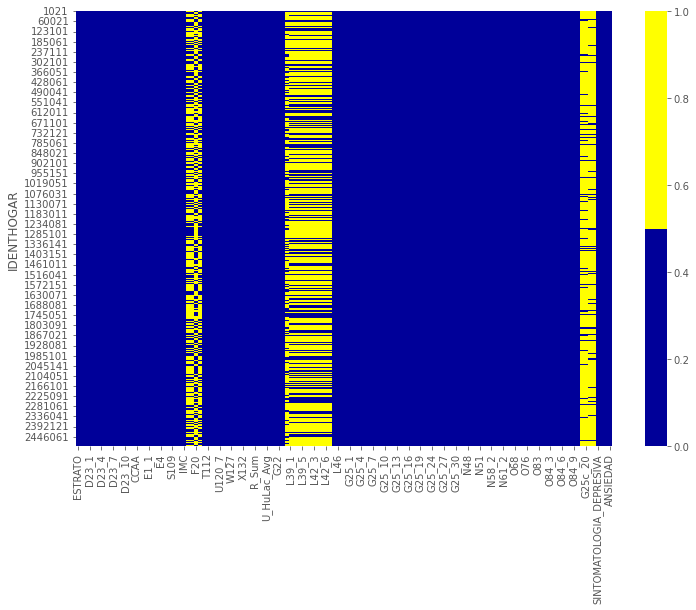

In [116]:
cols = df_full.columns
colours = ['#000099', '#ffff00']
sns.heatmap(df_full[cols].isnull(), cmap=sns.color_palette(colours))

In [117]:
r = df_full.isnull().any()
print (r[r].index)
len(r[r].index)

Index(['F18a_2', 'F19a_2', 'F20', 'J30', 'G24', 'L39_1', 'L39_3', 'L39_4',
       'L39_5', 'L42_1', 'L42_2', 'L42_3', 'L42_4', 'L42_5', 'L42_6', 'L42_7',
       'G25b_20', 'G25c_20', 'G25b_21', 'G25c_21'],
      dtype='object')


20

Se observa que aún tenemos 20 atributos con esta condición, por lo que realizamos un tratamiento específico a cada caso. Volvemos a hacer uso de los ficheros de diseño de registro para entender su significado

Los atributos Fxx, tienen relación con la actividad económica del individuo, tienen relación entre sí, por lo que completamos los missing_values con la respuesta "No Contesta"

In [118]:
df_full['F18a_2'] = df_full['F18a_2'].fillna(0)
df_full['F19a_2'] = df_full['F19a_2'].fillna(0)
df_full['F20'] = df_full['F20'].fillna(9)
df_full['J30'] = df_full['J30'].fillna(9)

Igualmente hacemos con el atributo G24

In [119]:
df_full['G24'] = df_full['G24'].fillna(9)

Los atributos Lxx, tienen relación con la limitación de actividades cotidianas, por lo que creamos un atributo sintético, que agrupe si tiene dificultad o no en estas tareas. Y se eliminan las variables individuales.

In [120]:
df_full['L39_1'] = df_full['L39_1'].fillna(9)
df_full['L39_3'] = df_full['L39_3'].fillna(9)
df_full['L39_4'] = df_full['L39_4'].fillna(9)
df_full['L39_5'] = df_full['L39_5'].fillna(9)
df_full['L42_1'] = df_full['L42_1'].fillna(9)
df_full['L42_2'] = df_full['L42_2'].fillna(9)
df_full['L42_3'] = df_full['L42_3'].fillna(9)
df_full['L42_4'] = df_full['L42_4'].fillna(9)
df_full['L42_5'] = df_full['L42_5'].fillna(9)
df_full['L42_6'] = df_full['L42_6'].fillna(9)
df_full['L42_7'] = df_full['L42_7'].fillna(9)

In [121]:
#Funciones creadas en utilidades.py
df_full['L39'] = df_full.apply(ut.act_diaria, axis=1)
df_full['L42'] = df_full.apply(ut.act_hogar, axis=1)

In [122]:
df_full_drop = ['L39_1','L39_3','L39_4','L39_5','L42_1','L42_2','L42_3','L42_4','L42_5','L42_6','L42_7']
df_full.drop(df_full_drop,axis=1,inplace=True)

Y, los atributos G25x_20 y G25x_21, los mantenemos en el dataset, pero completamos los null con "no contesta"

In [123]:
df_full['G25b_20'] = df_full['G25b_20'].fillna(9)
df_full['G25c_20'] = df_full['G25c_20'].fillna(9)
df_full['G25b_21'] = df_full['G25b_21'].fillna(9)
df_full['G25c_21'] = df_full['G25c_21'].fillna(9)

Se revisa nuevamente si queda algún atributo con valores null

<AxesSubplot:ylabel='IDENTHOGAR'>

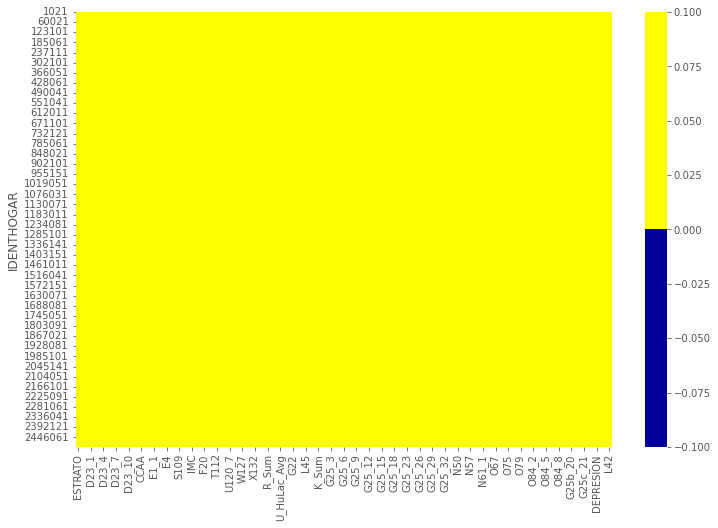

In [124]:
cols = df_full.columns
colours = ['#000099', '#ffff00']
sns.heatmap(df_full[cols].isnull(), cmap=sns.color_palette(colours))

In [125]:
r = df_full.isnull().any()
print (r[r].index)
len(r[r].index)

Index([], dtype='object')


0

In [126]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Columns: 127 entries, ESTRATO to L42
dtypes: Int64(32), int64(95)
memory usage: 23.0 MB


En este punto tenemos un dataset con 129 atributos, y se procede a crear un nuevo punto de control, con el conjunto de datos que se utilizará en la siguiente fase del proceso KDD.

In [127]:
df_full.to_csv('full2020.csv')

### 8.- Reducción de los datos

En los pasos anteriores concatenamos varios conjuntos de datos, donde las variables objetivos (ansiedad y depresión) han quedado en columnas intermedias.

Por orden y mejor entendimiento en el análisis, reordenamos el dataframe, para que queden en las dos columnas finales.

In [129]:
df_clase_temp = df_full[['SINTOMATOLOGIA_DEPRESIVA','CUADROS_DEPRESIVOS','DEPRESION','ANSIEDAD']]

In [130]:
df_full.drop(['SINTOMATOLOGIA_DEPRESIVA','CUADROS_DEPRESIVOS','DEPRESION','ANSIEDAD'],axis=1,inplace=True)

In [131]:
df_full = pd.concat([df_full,df_clase_temp],axis=1)

In [132]:
df_full.head()

,ESTRATO,A11_i,A12,D23_1,D23_2,D23_3,D23_4,D23_5,D23_6,D23_7,...,G25b_20,G25c_20,G25b_21,G25c_21,L39,L42,SINTOMATOLOGIA_DEPRESIVA,CUADROS_DEPRESIVOS,DEPRESION,ANSIEDAD
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
1021,1,3,1,2,2,1,2,2,2,2,...,1,1,1,1,2,1,4,1,1,1
1031,1,1,3,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2
1041,1,1,4,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2
1071,1,6,2,2,2,1,2,2,2,2,...,9,9,9,9,2,2,1,2,2,2
1101,1,1,3,1,2,2,2,2,2,2,...,9,9,9,9,2,2,1,3,2,2


#### 8.1 - Análisis de valores repetidos

Los atributos cuyos valores tienden a ser constantes; es decir, tienen el mismo valor en todos sus registros, suelen aportar desinformación al modelo.

Así que procedemos a ver que variables muestran mucha repetitividad (>95%) sobre uno de sus valores, una vez filtrados los atributos, vemos si tienen alguna significancia con la depresión o la ansiedad

In [133]:
filas = len(df_full.index)
info = [] 

for col in df_full.columns:
    contar = df_full[col].value_counts(dropna=False)
    top_pct = (contar/filas).iloc[0]
    
    if top_pct > 0.95:
        info.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(contar)
        print()

D23_4: 95.56519%
2       21829
1        1013
<NA>        0
Name: D23_4, dtype: Int64

D23_5: 98.65598%
2       22535
1         307
<NA>        0
Name: D23_5, dtype: Int64

D23_6: 99.88617%
2       22816
1          26
<NA>        0
Name: D23_6, dtype: Int64

D23_7: 99.77235%
2       22790
1          52
<NA>        0
Name: D23_7, dtype: Int64

D23_8: 96.32256%
2       22002
1         840
<NA>        0
Name: D23_8, dtype: Int64

D23_9: 98.63847%
2       22531
1         311
<NA>        0
Name: D23_9, dtype: Int64

D23_10: 99.89931%
2       22819
1          23
<NA>        0
Name: D23_10, dtype: Int64

D23_11: 99.60599%
2       22752
1          90
<NA>        0
Name: D23_11, dtype: Int64

K_Sum: 97.52211%
1    22276
2      566
Name: K_Sum, dtype: int64

G25_2: 97.68847%
2    22314
1      518
3       10
Name: G25_2, dtype: int64

G25_3: 97.60091%
2    22294
1      538
3       10
Name: G25_3, dtype: int64

G25_11: 95.08800%
2    21720
1     1086
3       36
Name: G25_11, dtype: int64

G25_13: 9

In [134]:
len(info)

32

Se encuentra entonces que hay 34 atributos que sus registros tienen el mismo valor.

Que siguiendo el significado de cada uno según el registro de diseño de las encuentas, son valores que responden a preguntas SI o NO.

In [135]:
print(info)

['D23_4', 'D23_5', 'D23_6', 'D23_7', 'D23_8', 'D23_9', 'D23_10', 'D23_11', 'K_Sum', 'G25_2', 'G25_3', 'G25_11', 'G25_13', 'G25_19', 'G25_22', 'G25_23', 'G25_26', 'G25_29', 'G25_30', 'G25_31', 'N58_2', 'N61_1', 'N61_2', 'O84_1', 'O84_2', 'O84_3', 'O84_5', 'O84_6', 'O84_7', 'O84_8', 'O84_9', 'L39']


In [136]:
att_no_significativo = ['D23_4','D23_5','D23_6','D23_7','D23_8','D23_9','D23_10','D23_11','G25_2','G25_3',
                       'G25_11','G25_13','G25_17','G25_18','G25_19','G25_22','G25_23','G25_26','G25_29',
                       'G25_30','G25_31','G25_32','N58_2','N61_1','N61_2','O84_2','O84_3','O84_5','O84_6',
                       'O84_7','O84_8','O84_9']

Inspeccionando cada una de estas variables según su significado en la encuesta, se procede a descartar todos los atributos, con mas del 95% de respuesta NO, ya que se asume que su no existencia no influye en la depresión o la ansiedad.

Unicamente dejamos en el dataset los atributos con mas de un 95% de SI

In [137]:
df_full.drop(att_no_significativo,axis=1,inplace=True)

#### 8.2 - Cambio de nombre de los atributos

Un paso que no se ha ejecutado hasta el momento, es adaptar los códigos de las variables origen con una nomenclatura que tenga mas significancia en las siguientes fases. Asñi, se facilita la inspección y análisis en la fase del análisis exploratorio.

In [138]:
df_full.columns

Index(['ESTRATO', 'A11_i', 'A12', 'D23_1', 'D23_2', 'D23_3', 'D26', 'CCAA',
       'SEXOa', 'EDADa', 'E1_1', 'E2_1a', 'E2_1b', 'E4', 'E4b', 'ESTUDIOS',
       'S109', 'S110', 'CLASE_PR', 'IMC', 'F18a_2', 'F19a_2', 'F20', 'J30',
       'T111', 'T112', 'U120_2', 'U120_4', 'U120_7', 'U120_8', 'V121', 'W127',
       'X130', 'X131', 'X132', 'Y133', 'Y135', 'R_Sum', 'U_fruta_Avg',
       'U_NoFood_Avg', 'U_HuLac_Avg', 'U_Carb_Avg', 'G21', 'G22', 'G23', 'G24',
       'L45', 'L46', 'H_Sum', 'K_Sum', 'G25_1', 'G25_4', 'G25_5', 'G25_6',
       'G25_7', 'G25_8', 'G25_9', 'G25_10', 'G25_12', 'G25_14', 'G25_15',
       'G25_16', 'G25_24', 'G25_25', 'G25_27', 'G25_28', 'N48', 'N49', 'N50',
       'N51', 'N53', 'N57', 'N58_3', 'O66', 'O67', 'O68', 'O71', 'O75', 'O76',
       'O78', 'O79', 'O83', 'O84_1', 'O84_4', 'P_Sum', 'G25b_20', 'G25c_20',
       'G25b_21', 'G25c_21', 'L39', 'L42', 'SINTOMATOLOGIA_DEPRESIVA',
       'CUADROS_DEPRESIVOS', 'DEPRESION', 'ANSIEDAD'],
      dtype='object')

In [139]:
df_full.rename(columns={'ESTRATO' : 'tipo_municipio',
                        'A11_i'   : 'situacion_laboral',
                        'A12'     : 'tipo_hogar',
                        'D23_1'   : 'tipo_contrato',
                        'D23_2'   : 'tipo_ayuda',
                        'D23_3'   : 'tipo_jubilacion',
                        'D26'     : 'salario_neto',
                        'CCAA'    : 'comunidad_autonoma',
                        'SEXOa'   : 'sexo',
                        'EDADa'   : 'edad',
                        'E1_1'    : 'pais_nacimiento',
                        'E2_1a'   : 'nacionalidad_espanola',
                        'E2_1b'   : 'nacionalidad_extranjera',
                        'E4'      : 'tipo_convivencia',
                        'E4b'     : 'estado_civil',
                        'ESTUDIOS': 'nivel_estudios',
                        'S109'    : 'altura',
                        'S110'    : 'peso',
                        'CLASE_PR': 'clase_social',
                        'IMC'     : 'imc',
                        'F18a_2'  : 'actividad_empresa',
                        'F19a_2'  : 'ocupacion',
                        'F20'     : 'situacion_profesional',
                        'J30'     : 'ausencia_laboral12m',
                        'T111'    : 'tipo_actfisica',
                        'T112'    : 'frecuencia_actfisica',
                        'U120_2'  : 'frecuencia_consumocarne',
                        'U120_4'  : 'frecuencia_consumopescado',
                        'U120_7'  : 'frecuencia_consumoverdura',
                        'U120_8'  : 'frecuencia_consumolegumbre',
                        'V121'    : 'fumador',
                        'W127'    : 'frecuencia_consumoalcohol',
                        'X130'    : 'apoyosocial_cuantos',
                        'X131'    : 'apoyosocial_interes',
                        'X132'    : 'apoyosocial_ayuda',
                        'Y133'    : 'cuidado_personas',
                        'Y135'    : 'cuidado_horas',
                        'R_Sum'   : 'falta_atencionsanitaria',
                        'U_fruta_Avg' : 'frecuencia_consumofruta',
                        'U_NoFood_Avg': 'frecuencia_consumoprocesado',
                        'U_HuLac_Avg' : 'frecuencia_consumohuevoslacteos',
                        'U_Carb_Avg'  : 'frecuencia_consumocarbohidratos',
                        'G21'     : 'estado_salud12m',
                        'G22'     : 'estado_saludcronico',
                        'G23'     : 'limitacion_salud6m',
                        'G24'     : 'tipo_problemasalud',
#                        'G24a'    : 'estado_saludbucodental',
#                        'K38a'    : 'dificultad_concentracion',
                        'L45'     : 'dolor_4semanas',
                        'L46'     : 'dolor_limitacion',
                        'H_Sum'   : 'accidentes_12meses',
                        'K_Sum'   : 'limitacion_fisica',
                        'G25_1'   : 'tension_alta',
                        'G25_4'   : 'enfermedad_corazon',
                        'G25_5'   : 'varices',
                        'G25_6'   : 'artrosis',
                        'G25_7'   : 'dolor_cervical',
                        'G25_8'   : 'dolor_lumbar',
                        'G25_9'   : 'alergias',
                        'G25_10'  : 'asma',
                        'G25_12'  : 'diabetes',
                        'G25_14'  : 'orina',
                        'G25_15'  : 'colesterol',
                        'G25_16'  : 'cataratas',
                        'G25_24'  : 'migrana',
                        'G25_25'  : 'hemorroides',
                        'G25_27'  : 'osteoporosis',
                        'G25_28'  : 'tiroides',
                        'N48'     : 'ultima_consultamedica',
                        'N49'     : 'cantidad_consultageneral4sem',
                        'N50'     : 'tiempo_ultimaconsulta',
                        'N51'     : 'cantidad_consultaespecialista4sem',
                        'N53'     : 'lugar_consulta4sem',
                        'N57'     : 'tipo_consultamedica',
                        'N58_3'   : 'consulta_enfermeria12m',
                        'O66'     : 'ingreso_hospital12m',
                        'O67'     : 'cantidad_ingresohospital12m',
                        'O68'     : 'numero_nocheshospital12m',
                        'O71'     : 'motivo_ingresohospital',
                        'O75'     : 'ingreso_hospitaldia12m',
                        'O76'     : 'cantidad_ingresohospitaldia12m',
                        'O78'     : 'urgencia_12meses',
                        'O79'     : 'cantidad_urgencias12m',
                        'O83'     : 'tipo_urgencia',
                        'O84_1'   : 'uso_sanidadpublica',
                        'O84_4'   : 'uso_seguroprivado',
                        'P_Sum'   : 'consumo_medicamentos',
                        'G25b_20' : 'depresion_12meses',
                        'G25c_20' : 'depresion_diagnosticomedico',
                        'G25b_21' : 'ansiedad_12meses',
                        'G25c_21' : 'ansiedad_diagnosticomedico',
                        'L39'     : 'dificultad_actdiaria',
                        'L42'     : 'dificultad_acthogar',
                        'SINTOMATOLOGIA_DEPRESIVA' : 'nivel_depresion',
                        'CUADROS_DEPRESIVOS'  : 'prevalencia_depresion',
                        'DEPRESION' : 'depresion',
                        'ANSIEDAD' : 'ansiedad'}, inplace=True)

In [140]:
df_full.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,depresion_12meses,depresion_diagnosticomedico,ansiedad_12meses,ansiedad_diagnosticomedico,dificultad_actdiaria,dificultad_acthogar,nivel_depresion,prevalencia_depresion,depresion,ansiedad
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
1021,1,3,1,2,2,1,2,16,2,81,...,1,1,1,1,2,1,4,1,1,1
1031,1,1,3,1,2,2,5,16,1,38,...,9,9,9,9,2,2,1,3,2,2
1041,1,1,4,1,2,2,5,16,1,63,...,9,9,9,9,2,2,1,3,2,2
1071,1,6,2,2,2,1,1,16,1,69,...,9,9,9,9,2,2,1,2,2,2
1101,1,1,3,1,2,2,5,16,2,48,...,9,9,9,9,2,2,1,3,2,2


#### 8.3- Creación de los conjuntos de datos de estudio

La fase de limpieza y preprocesamiento de datos, se ha realizado inspeccionando si las variables tienen o no relación con la ansiedad o la depresión.

Pero, para el análisis exploratorio y posterior construcción de los modelos, se debe analizar cada enfermedad por separado.

Por lo que creamos dos conjuntos de datos con una sola variable objetivo por enfermedad.

Se crea un dataset con los atributos generales, no relacionados directamente con ninguna de las enfermedades

In [141]:
att_generales = ['tipo_municipio', 'situacion_laboral', 'tipo_hogar', 'tipo_contrato',
       'tipo_ayuda', 'tipo_jubilacion', 'salario_neto', 'comunidad_autonoma', 'sexo', 'edad', 'pais_nacimiento',
       'nacionalidad_espanola', 'nacionalidad_extranjera', 'tipo_convivencia',
       'estado_civil', 'nivel_estudios', 'altura', 'peso', 'clase_social',
       'imc', 'actividad_empresa', 'ocupacion', 'situacion_profesional',
       'ausencia_laboral12m', 'tipo_actfisica', 'frecuencia_actfisica',
       'frecuencia_consumocarne', 'frecuencia_consumopescado',
       'frecuencia_consumoverdura', 'frecuencia_consumolegumbre', 'fumador',
       'frecuencia_consumoalcohol', 'apoyosocial_cuantos',
       'apoyosocial_interes', 'apoyosocial_ayuda', 'cuidado_personas',
       'cuidado_horas', 'falta_atencionsanitaria', 'frecuencia_consumofruta',
       'frecuencia_consumoprocesado', 'frecuencia_consumohuevoslacteos',
       'frecuencia_consumocarbohidratos', 'estado_salud12m',
       'estado_saludcronico', 'limitacion_salud6m', 'tipo_problemasalud',
       'dolor_4semanas',
       'dolor_limitacion', 'accidentes_12meses', 'limitacion_fisica',
       'tension_alta', 'enfermedad_corazon', 'varices', 'artrosis',
       'dolor_cervical', 'dolor_lumbar', 'alergias', 'asma', 'diabetes',
       'orina', 'colesterol', 'cataratas', 'migrana', 'hemorroides',
       'osteoporosis', 'tiroides', 'ultima_consultamedica',
       'cantidad_consultageneral4sem', 'tiempo_ultimaconsulta',
       'cantidad_consultaespecialista4sem', 'lugar_consulta4sem',
       'tipo_consultamedica', 'consulta_enfermeria12m', 'ingreso_hospital12m',
       'cantidad_ingresohospital12m', 'numero_nocheshospital12m',
       'motivo_ingresohospital', 'ingreso_hospitaldia12m',
       'cantidad_ingresohospitaldia12m', 'urgencia_12meses',
       'cantidad_urgencias12m', 'tipo_urgencia', 'uso_sanidadpublica',
       'uso_seguroprivado', 'consumo_medicamentos','dificultad_actdiaria',
       'dificultad_acthogar']

In [142]:
df_variables = df_full[att_generales]

##### 8.3.1- Dataset "Depresión"

Se crea un dataset con las variables asociadas con la depresión, incluyendo el target "depresion"

In [143]:
att_depresion = ['depresion_12meses','depresion_diagnosticomedico','nivel_depresion', 'prevalencia_depresion',
                 'depresion']

In [144]:
df_variables_depresion = df_full[att_depresion]

In [145]:
df_depresion = pd.concat([df_variables,df_variables_depresion],axis=1)

In [146]:
df_depresion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   tipo_municipio                     22842 non-null  int64
 1   situacion_laboral                  22842 non-null  int64
 2   tipo_hogar                         22842 non-null  int64
 3   tipo_contrato                      22842 non-null  Int64
 4   tipo_ayuda                         22842 non-null  Int64
 5   tipo_jubilacion                    22842 non-null  Int64
 6   salario_neto                       22842 non-null  int64
 7   comunidad_autonoma                 22842 non-null  int64
 8   sexo                               22842 non-null  int64
 9   edad                               22842 non-null  int64
 10  pais_nacimiento                    22842 non-null  int64
 11  nacionalidad_espanola              22842 non-null  int64
 12  nacionalidad_

##### 8.3.2- Dataset "Ansiedad"

Se crea un dataset con las variables asociadas con la ansiedad, incluyendo el target "ansiedad"

In [147]:
att_ansiedad = ['ansiedad_12meses','ansiedad_diagnosticomedico','ansiedad']

In [148]:
df_variables_ansiedad = df_full[att_ansiedad]

In [149]:
df_ansiedad = pd.concat([df_variables,df_variables_ansiedad],axis=1)

In [150]:
df_ansiedad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22842 entries, 1021 to 2497151
Data columns (total 90 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   tipo_municipio                     22842 non-null  int64
 1   situacion_laboral                  22842 non-null  int64
 2   tipo_hogar                         22842 non-null  int64
 3   tipo_contrato                      22842 non-null  Int64
 4   tipo_ayuda                         22842 non-null  Int64
 5   tipo_jubilacion                    22842 non-null  Int64
 6   salario_neto                       22842 non-null  int64
 7   comunidad_autonoma                 22842 non-null  int64
 8   sexo                               22842 non-null  int64
 9   edad                               22842 non-null  int64
 10  pais_nacimiento                    22842 non-null  int64
 11  nacionalidad_espanola              22842 non-null  int64
 12  nacionalidad_

Los dos datasets tienen todas las variables del dataset concatenado asociadas a la enfermedad a analizar, y el target (ansiedad o depresión).

Guardamos en un fichero .csv ambos datasets

In [151]:
df_ansiedad.to_csv('ansiedad2014.csv')
df_depresion.to_csv('depresion2014.csv')

#### 8.4- Normalización de los datos de entrada

Es importante normalizar antes de ejecutar los modelos para tener un rango definido de todas las variables que forman parte del algoritmo.

Uno de los detalles interesantes del conjunto de datos, es que hasta ahora hemos estado trabajando con variables numéricas discretas. En ningún momento se han utilizado variables categóricas.

Así, que la normalización de las variables para su posterior estudio de correlación, se centra solo en normalizar o escalar. No se aplicarán técnicas de One-Hot Encoding orientadas a discretizar variables categóricas.

En este caso aplicaremos el "escalado" (0-1) de las variables, porque estamos trabajando en valores positivos. 

Este paso solo aplica a las variables, dejando por fuera al target.

Aún no se han hecho inspecciones sobre valores atípicos(outliers), principalmente por la gran cantidad de variables y porque todos los registros aportan una respuesta necesaria para la detección de patrones asociados a la ansiedad o la depresión

Por ello se utilizará el método de escalado "QuantileTransformer", que es un método ofrecido por scikit-learn, que toma en cuenta este tipo de datos en su normalización para agruparlos en el rango.

In [152]:
df_ansiedad.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,cantidad_urgencias12m,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,ansiedad_12meses,ansiedad_diagnosticomedico,ansiedad
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
1021,1,3,1,2,2,1,2,16,2,81,...,1,4,1,1,10,2,1,1,1,1
1031,1,1,3,1,2,2,5,16,1,38,...,0,9,1,2,4,2,2,9,9,2
1041,1,1,4,1,2,2,5,16,1,63,...,0,9,1,1,1,2,2,9,9,2
1071,1,6,2,2,2,1,1,16,1,69,...,0,9,1,2,0,2,2,9,9,2
1101,1,1,3,1,2,2,5,16,2,48,...,0,9,1,2,0,2,2,9,9,2


In [153]:
df_depresion.head()

,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,edad,...,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,depresion_12meses,depresion_diagnosticomedico,nivel_depresion,prevalencia_depresion,depresion
IDENTHOGAR,,,,,,,,,,,,,,,,,,,,,
1021,1,3,1,2,2,1,2,16,2,81,...,1,1,10,2,1,1,1,4,1,1
1031,1,1,3,1,2,2,5,16,1,38,...,1,2,4,2,2,9,9,1,3,2
1041,1,1,4,1,2,2,5,16,1,63,...,1,1,1,2,2,9,9,1,3,2
1071,1,6,2,2,2,1,1,16,1,69,...,1,2,0,2,2,9,9,1,2,2
1101,1,1,3,1,2,2,5,16,2,48,...,1,2,0,2,2,9,9,1,3,2


In [154]:
# Eliminamos las variables objetivo de los dataset, para proceder al análisis de correlaciones y variables 
#significativas
X_ansiedad = df_ansiedad.drop('ansiedad', axis=1)
X_depresion = df_depresion.drop('depresion', axis=1)

In [155]:
# Se crean los dataset con las variables objetivo
y_ansiedad = df_ansiedad.ansiedad
y_depresion = df_depresion.depresion

In [156]:
print(y_ansiedad.value_counts())
print(y_depresion.value_counts())

2    20658
1     2184
Name: ansiedad, dtype: int64
2    20139
1     2703
Name: depresion, dtype: int64


In [157]:
qt = QuantileTransformer(random_state=123)

In [158]:
X_ansiedad_norm = qt.fit_transform(X_ansiedad)
X_depresion_norm = qt.fit_transform(X_depresion)

In [159]:
#Reconstruimos los Dataframes
df_ansiedad_norm = pd.DataFrame(X_ansiedad_norm, columns=X_ansiedad.columns,
                                     index=X_ansiedad.index)
df_depresion_norm = pd.DataFrame(X_depresion_norm, columns=X_depresion.columns,
                                     index=X_depresion.index)

In [160]:
#Hago un reset en los indices
df_ansiedad_norm=df_ansiedad_norm.reset_index()
df_depresion_norm=df_depresion_norm.reset_index()

In [161]:
df_ansiedad_norm.head()

,IDENTHOGAR,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,...,urgencia_12meses,cantidad_urgencias12m,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,ansiedad_12meses,ansiedad_diagnosticomedico
0,1021,0.233734,0.688188,0.000000,1.0,1.0,0.0,0.335335,0.921922,1.0,...,0.0,0.818819,0.261762,0.0,0.0,0.997497,1.0,0.0,0.0,0.0
1,1031,0.233734,0.000000,0.618619,0.0,1.0,1.0,0.773774,0.921922,0.0,...,1.0,0.000000,1.000000,0.0,1.0,0.845846,1.0,1.0,1.0,1.0
2,1041,0.233734,0.000000,0.794795,0.0,1.0,1.0,0.773774,0.921922,0.0,...,1.0,0.000000,1.000000,0.0,0.0,0.421922,1.0,1.0,1.0,1.0
3,1071,0.233734,0.949950,0.359359,1.0,1.0,0.0,0.000000,0.921922,0.0,...,1.0,0.000000,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0
4,1101,0.233734,0.000000,0.618619,0.0,1.0,1.0,0.773774,0.921922,1.0,...,1.0,0.000000,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0


In [162]:
df_depresion_norm.head()

,IDENTHOGAR,tipo_municipio,situacion_laboral,tipo_hogar,tipo_contrato,tipo_ayuda,tipo_jubilacion,salario_neto,comunidad_autonoma,sexo,...,tipo_urgencia,uso_sanidadpublica,uso_seguroprivado,consumo_medicamentos,dificultad_actdiaria,dificultad_acthogar,depresion_12meses,depresion_diagnosticomedico,nivel_depresion,prevalencia_depresion
0,1021,0.233734,0.688188,0.000000,1.0,1.0,0.0,0.335335,0.921922,1.0,...,0.261762,0.0,0.0,0.997497,1.0,0.0,0.0,0.0,0.97047,0.000000
1,1031,0.233734,0.000000,0.618619,0.0,1.0,1.0,0.773774,0.921922,0.0,...,1.000000,0.0,1.0,0.845846,1.0,1.0,1.0,1.0,0.00000,0.538038
2,1041,0.233734,0.000000,0.794795,0.0,1.0,1.0,0.773774,0.921922,0.0,...,1.000000,0.0,0.0,0.421922,1.0,1.0,1.0,1.0,0.00000,0.538038
3,1071,0.233734,0.949950,0.359359,1.0,1.0,0.0,0.000000,0.921922,0.0,...,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0,0.00000,0.061562
4,1101,0.233734,0.000000,0.618619,0.0,1.0,1.0,0.773774,0.921922,1.0,...,1.000000,0.0,1.0,0.000000,1.0,1.0,1.0,1.0,0.00000,0.538038


#### 8.5- Estudio de correlaciones y características significativas

Para el estudio de las correlaciones y selección de variables sognificativas, se hará uso de una herramienta de reducción de la dimensional disponible en GitHub y escrita por Will Koehrsen.

[feature-selector](https://github.com/WillKoehrsen/feature-selector.git)

Esta herramienta consta de cinco métodos para poder ser usados en la fase de Reducción de Datos.

En el caso de este proyecto, solo se hará uso de las siguientes:

* __Estudio de Correlaciones:__ este método haciendo uso del coeficiente de Peason, permite analizar colinealidades en parejas de variables; tras varias pruebas se decide como estrategia del análisis seleccionar las correlaciones mayores a 0.90
* __Características sin Importancia__: este método haciendo uso de la libreria [LightGBM library](https://lightgbm.readthedocs.io/en/latest/index.html), ejecuta un conjunto de modelo basado en la potenciación del gradiente, para determinar la importancia de todas las variables respecto a al clase que se quiere identificar. En este primer método identificar las que devuelven un valor de 0.
* __Características con baja Importancia__: como resultado del método anterior, se escogen que variables tienen una baja infñuencia en la clase a identificar, seleccionando como estrategía el porcentaje de variables que explicarían la clase. En este caso se ha seleccionado el valor de 0.99

Por último, esta herramienta es capaz de identificar y borrar las variables que se descartan de los trés métodos anteriores.

In [163]:
fs_ansiedad = FeatureSelector(data = df_ansiedad_norm, labels= y_ansiedad)
fs_depresion = FeatureSelector(data = df_depresion_norm, labels= y_depresion)

##### 8.5.1- Dataset "Ansiedad"

In [164]:
fs_ansiedad.identify_collinear(correlation_threshold=0.90)

14 features with a correlation magnitude greater than 0.90.



In [165]:
correlated_features = fs_ansiedad.ops['collinear']
correlated_features

['nacionalidad_extranjera',
 'ocupacion',
 'ausencia_laboral12m',
 'cuidado_horas',
 'tipo_problemasalud',
 'cantidad_consultageneral4sem',
 'tipo_consultamedica',
 'cantidad_ingresohospital12m',
 'numero_nocheshospital12m',
 'motivo_ingresohospital',
 'cantidad_ingresohospitaldia12m',
 'cantidad_urgencias12m',
 'tipo_urgencia',
 'ansiedad_diagnosticomedico']

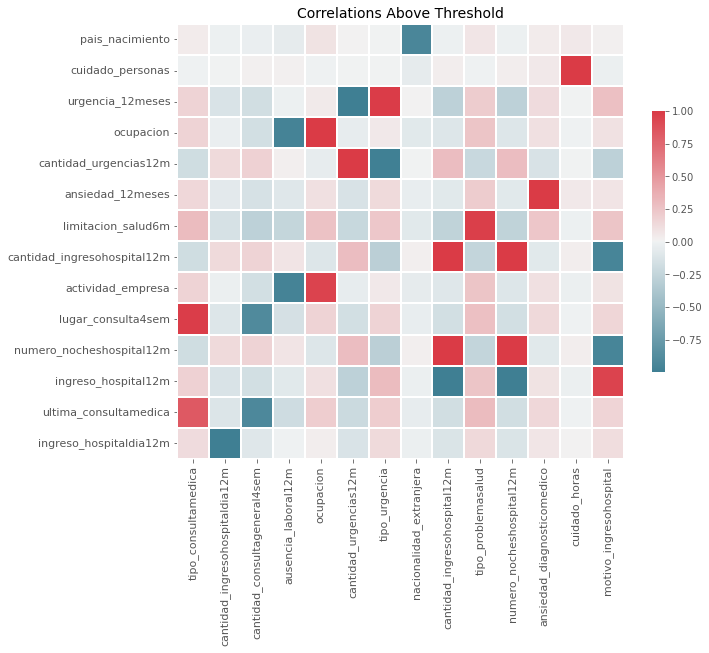

In [166]:
fs_ansiedad.plot_collinear()

In [167]:
fs_ansiedad.record_collinear

,drop_feature,corr_feature,corr_value
0,nacionalidad_extranjera,pais_nacimiento,-0.929151
1,ocupacion,actividad_empresa,0.94725
2,ausencia_laboral12m,actividad_empresa,-0.963874
3,ausencia_laboral12m,ocupacion,-0.96087
4,cuidado_horas,cuidado_personas,0.993054
5,tipo_problemasalud,limitacion_salud6m,0.974982
6,cantidad_consultageneral4sem,ultima_consultamedica,-0.916094
7,tipo_consultamedica,lugar_consulta4sem,0.981772
8,cantidad_ingresohospital12m,ingreso_hospital12m,-0.995893
9,numero_nocheshospital12m,ingreso_hospital12m,-0.995721


In [168]:
fs_ansiedad.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model


80 features with zero importance after one-hot encoding.



In [169]:
zero_importance_features = fs_ansiedad.ops['zero_importance']
print(zero_importance_features)

['sexo', 'pais_nacimiento', 'cantidad_consultageneral4sem', 'ultima_consultamedica', 'tiroides', 'osteoporosis', 'hemorroides', 'migrana', 'cataratas', 'colesterol', 'orina', 'diabetes', 'asma', 'alergias', 'dolor_lumbar', 'dolor_cervical', 'artrosis', 'varices', 'enfermedad_corazon', 'tiempo_ultimaconsulta', 'cantidad_consultaespecialista4sem', 'tipo_hogar', 'cantidad_urgencias12m', 'situacion_laboral', 'dificultad_acthogar', 'dificultad_actdiaria', 'consumo_medicamentos', 'uso_seguroprivado', 'uso_sanidadpublica', 'tipo_urgencia', 'urgencia_12meses', 'tipo_consultamedica', 'cantidad_ingresohospitaldia12m', 'ingreso_hospitaldia12m', 'motivo_ingresohospital', 'numero_nocheshospital12m', 'cantidad_ingresohospital12m', 'ingreso_hospital12m', 'consulta_enfermeria12m', 'tension_alta', 'limitacion_fisica', 'accidentes_12meses', 'imc', 'frecuencia_consumocarne', 'tipo_contrato', 'tipo_actfisica', 'ausencia_laboral12m', 'situacion_profesional', 'tipo_ayuda', 'actividad_empresa', 'clase_social

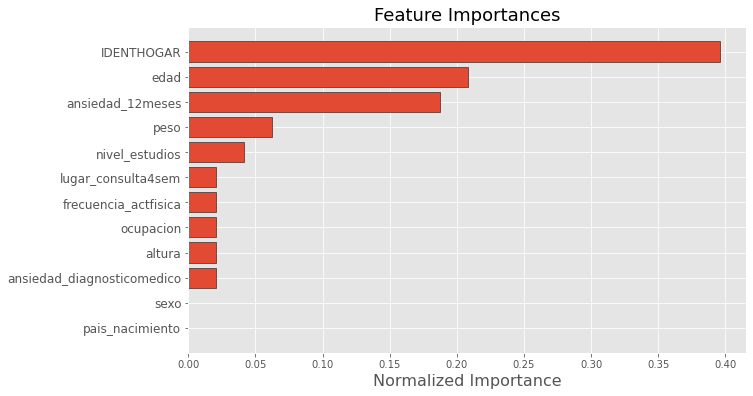

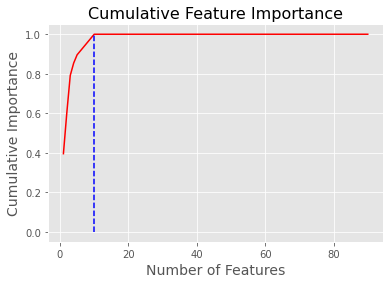

10 features required for 0.99 of cumulative importance


In [170]:
fs_ansiedad.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [171]:
fs_ansiedad.feature_importances.head(9)

,feature,importance,normalized_importance,cumulative_importance
0,IDENTHOGAR,1.9,0.395833,0.395833
1,edad,1.0,0.208333,0.604167
2,ansiedad_12meses,0.9,0.187500,0.791667
3,peso,0.3,0.062500,0.854167
4,nivel_estudios,0.2,0.041667,0.895833
5,lugar_consulta4sem,0.1,0.020833,0.916667
6,frecuencia_actfisica,0.1,0.020833,0.937500
7,ocupacion,0.1,0.020833,0.958333
8,altura,0.1,0.020833,0.979167


In [172]:
fs_ansiedad.identify_low_importance(cumulative_importance = 0.99)

9 features required for cumulative importance of 0.99 after one hot encoding.
81 features do not contribute to cumulative importance of 0.99.



In [173]:
low_importance_features = fs_ansiedad.ops['low_importance']
print(low_importance_features)

['tipo_convivencia', 'estado_civil', 'comunidad_autonoma', 'salario_neto', 'tipo_jubilacion', 'frecuencia_consumoverdura', 'clase_social', 'actividad_empresa', 'tipo_actfisica', 'situacion_profesional', 'ausencia_laboral12m', 'nacionalidad_extranjera', 'tipo_contrato', 'frecuencia_consumocarne', 'imc', 'accidentes_12meses', 'tipo_ayuda', 'nacionalidad_espanola', 'dolor_4semanas', 'frecuencia_consumolegumbre', 'apoyosocial_cuantos', 'apoyosocial_interes', 'apoyosocial_ayuda', 'cuidado_personas', 'cuidado_horas', 'falta_atencionsanitaria', 'fumador', 'frecuencia_consumofruta', 'frecuencia_consumohuevoslacteos', 'frecuencia_consumocarbohidratos', 'estado_salud12m', 'estado_saludcronico', 'tipo_municipio', 'tipo_problemasalud', 'limitacion_fisica', 'frecuencia_consumoprocesado', 'dolor_limitacion', 'frecuencia_consumopescado', 'tension_alta', 'motivo_ingresohospital', 'ingreso_hospital12m', 'dolor_cervical', 'dolor_lumbar', 'alergias', 'asma', 'diabetes', 'orina', 'colesterol', 'cataratas'

##### 8.5.2- Dataset "Depresion"

In [174]:
fs_depresion.identify_collinear(correlation_threshold=0.90)

14 features with a correlation magnitude greater than 0.90.



In [175]:
correlated_features2 = fs_depresion.ops['collinear']
correlated_features2

['nacionalidad_extranjera',
 'ocupacion',
 'ausencia_laboral12m',
 'cuidado_horas',
 'tipo_problemasalud',
 'cantidad_consultageneral4sem',
 'tipo_consultamedica',
 'cantidad_ingresohospital12m',
 'numero_nocheshospital12m',
 'motivo_ingresohospital',
 'cantidad_ingresohospitaldia12m',
 'cantidad_urgencias12m',
 'tipo_urgencia',
 'depresion_diagnosticomedico']

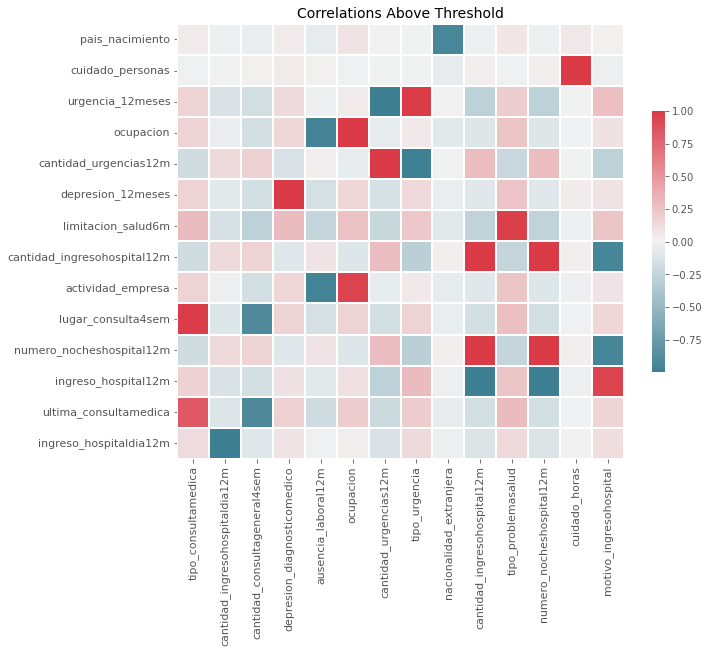

In [176]:
fs_depresion.plot_collinear()

In [177]:
fs_depresion.record_collinear

,drop_feature,corr_feature,corr_value
0,nacionalidad_extranjera,pais_nacimiento,-0.929151
1,ocupacion,actividad_empresa,0.94725
2,ausencia_laboral12m,actividad_empresa,-0.963874
3,ausencia_laboral12m,ocupacion,-0.96087
4,cuidado_horas,cuidado_personas,0.993054
5,tipo_problemasalud,limitacion_salud6m,0.974982
6,cantidad_consultageneral4sem,ultima_consultamedica,-0.916094
7,tipo_consultamedica,lugar_consulta4sem,0.981772
8,cantidad_ingresohospital12m,ingreso_hospital12m,-0.995893
9,numero_nocheshospital12m,ingreso_hospital12m,-0.995721


In [178]:
fs_depresion.identify_zero_importance(task = 'classification', eval_metric = 'auc', 
                            n_iterations = 10, early_stopping = True)

Training Gradient Boosting Model


71 features with zero importance after one-hot encoding.



In [179]:
zero_importance_features2 = fs_depresion.ops['zero_importance']
print(zero_importance_features2)

['tiempo_ultimaconsulta', 'cantidad_consultageneral4sem', 'ultima_consultamedica', 'tiroides', 'osteoporosis', 'alergias', 'colesterol', 'hemorroides', 'migrana', 'cataratas', 'asma', 'diabetes', 'orina', 'dolor_lumbar', 'ingreso_hospitaldia12m', 'lugar_consulta4sem', 'tipo_consultamedica', 'nivel_depresion', 'dificultad_acthogar', 'dificultad_actdiaria', 'consumo_medicamentos', 'uso_seguroprivado', 'uso_sanidadpublica', 'tipo_urgencia', 'cantidad_urgencias12m', 'urgencia_12meses', 'cantidad_ingresohospitaldia12m', 'artrosis', 'motivo_ingresohospital', 'cantidad_ingresohospital12m', 'ingreso_hospital12m', 'consulta_enfermeria12m', 'dolor_cervical', 'tipo_problemasalud', 'varices', 'fumador', 'frecuencia_consumoverdura', 'frecuencia_consumopescado', 'frecuencia_consumocarne', 'tipo_actfisica', 'ausencia_laboral12m', 'situacion_profesional', 'clase_social', 'estado_civil', 'nacionalidad_extranjera', 'nacionalidad_espanola', 'pais_nacimiento', 'sexo', 'tipo_jubilacion', 'tipo_ayuda', 'tip

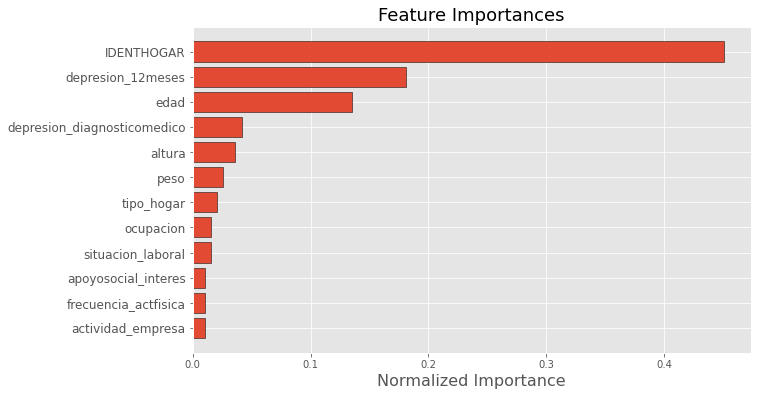

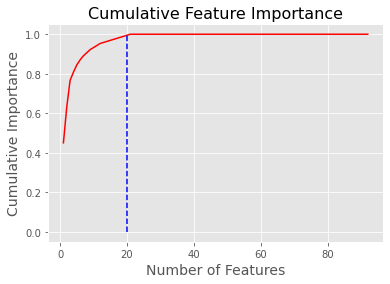

20 features required for 0.99 of cumulative importance


In [180]:
fs_depresion.plot_feature_importances(threshold = 0.99, plot_n = 12)

In [181]:
fs_depresion.feature_importances.head(39)

,feature,importance,normalized_importance,cumulative_importance
0,IDENTHOGAR,8.7,0.450777,0.450777
1,depresion_12meses,3.5,0.181347,0.632124
2,edad,2.6,0.134715,0.766839
3,depresion_diagnosticomedico,0.8,0.041451,0.808290
4,altura,0.7,0.036269,0.844560
5,peso,0.5,0.025907,0.870466
6,tipo_hogar,0.4,0.020725,0.891192
7,ocupacion,0.3,0.015544,0.906736
8,situacion_laboral,0.3,0.015544,0.922280
9,apoyosocial_interes,0.2,0.010363,0.932642


In [182]:
fs_depresion.identify_low_importance(cumulative_importance = 0.99)

19 features required for cumulative importance of 0.99 after one hot encoding.
73 features do not contribute to cumulative importance of 0.99.



In [183]:
low_importance_features2 = fs_depresion.ops['low_importance']
print(low_importance_features2)

['tipo_convivencia', 'tipo_ayuda', 'tipo_jubilacion', 'sexo', 'pais_nacimiento', 'nacionalidad_espanola', 'nacionalidad_extranjera', 'estado_civil', 'clase_social', 'situacion_profesional', 'ausencia_laboral12m', 'tipo_actfisica', 'frecuencia_consumocarne', 'frecuencia_consumopescado', 'frecuencia_consumoverdura', 'tipo_contrato', 'frecuencia_consumolegumbre', 'estado_saludcronico', 'enfermedad_corazon', 'cuidado_personas', 'cuidado_horas', 'falta_atencionsanitaria', 'frecuencia_consumofruta', 'frecuencia_consumoprocesado', 'frecuencia_consumohuevoslacteos', 'estado_salud12m', 'fumador', 'limitacion_salud6m', 'dolor_4semanas', 'dolor_limitacion', 'accidentes_12meses', 'limitacion_fisica', 'tension_alta', 'apoyosocial_cuantos', 'frecuencia_consumoalcohol', 'varices', 'cantidad_urgencias12m', 'dolor_cervical', 'orina', 'diabetes', 'asma', 'cataratas', 'migrana', 'hemorroides', 'dolor_lumbar', 'colesterol', 'osteoporosis', 'tiroides', 'ultima_consultamedica', 'cantidad_consultageneral4sem

##### 8.5.3- Variables a eliminar en la reducción de datos

In [184]:
all_to_remove = fs_ansiedad.check_removal()

Total of 82 features identified for removal


In [185]:
all_to_remove2 = fs_depresion.check_removal()

Total of 76 features identified for removal


In [186]:
print('Variables a descartar dataset ansiedad')
print(all_to_remove)
print('')
print('Variables a descartar dataset depresion')
print(all_to_remove2)

Variables a descartar dataset ansiedad
['salario_neto', 'enfermedad_corazon', 'tipo_urgencia', 'frecuencia_consumocarne', 'nacionalidad_extranjera', 'orina', 'osteoporosis', 'cuidado_horas', 'apoyosocial_interes', 'frecuencia_consumoprocesado', 'estado_salud12m', 'frecuencia_consumohuevoslacteos', 'tipo_municipio', 'clase_social', 'cantidad_ingresohospitaldia12m', 'tiroides', 'cataratas', 'situacion_profesional', 'varices', 'tension_alta', 'tipo_consultamedica', 'artrosis', 'situacion_laboral', 'consumo_medicamentos', 'asma', 'tipo_problemasalud', 'migrana', 'dolor_4semanas', 'actividad_empresa', 'cantidad_urgencias12m', 'alergias', 'tipo_jubilacion', 'apoyosocial_ayuda', 'cantidad_consultageneral4sem', 'cantidad_consultaespecialista4sem', 'ocupacion', 'nacionalidad_espanola', 'frecuencia_consumocarbohidratos', 'falta_atencionsanitaria', 'accidentes_12meses', 'colesterol', 'estado_civil', 'dificultad_actdiaria', 'ingreso_hospital12m', 'fumador', 'tiempo_ultimaconsulta', 'consulta_enfer

In [187]:
df_ansiedad_norm_c =  fs_ansiedad.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 82 features including one-hot features.


In [188]:
df_depresion_norm_c =  fs_depresion.remove(methods = 'all', keep_one_hot=False)

['collinear', 'zero_importance', 'low_importance'] methods have been run

Removed 76 features including one-hot features.


In [189]:
print('Original Number of Features', df_ansiedad_norm.shape[1])
print('Final Number of Features: ', df_ansiedad_norm_c.shape[1])

Original Number of Features 90
Final Number of Features:  8


In [190]:
print('Original Number of Features', df_depresion_norm.shape[1])
print('Final Number of Features: ', df_depresion_norm_c.shape[1])

Original Number of Features 92
Final Number of Features:  16


### 9.- Conjunto de datos para el análisis exploratorio

In [191]:
y_ansiedad = y_ansiedad.reset_index()

In [192]:
y_depresion = y_depresion.reset_index()

In [193]:
df_ansiedad_modelo = pd.concat([df_ansiedad_norm_c,y_ansiedad.ansiedad], axis=1)

In [194]:
df_depresion_modelo = pd.concat([df_depresion_norm_c,y_depresion.depresion], axis=1)

In [195]:
print(df_ansiedad_modelo.shape)
print(df_depresion_modelo.shape)

(22842, 9)
(22842, 17)


In [196]:
df_ansiedad_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22842 entries, 0 to 22841
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   IDENTHOGAR            22842 non-null  int64  
 1   edad                  22842 non-null  float64
 2   nivel_estudios        22842 non-null  float64
 3   altura                22842 non-null  float64
 4   peso                  22842 non-null  float64
 5   frecuencia_actfisica  22842 non-null  float64
 6   lugar_consulta4sem    22842 non-null  float64
 7   ansiedad_12meses      22842 non-null  float64
 8   ansiedad              22842 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 1.6 MB


In [197]:
df_depresion_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22842 entries, 0 to 22841
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   IDENTHOGAR                         22842 non-null  int64  
 1   tipo_municipio                     22842 non-null  float64
 2   situacion_laboral                  22842 non-null  float64
 3   tipo_hogar                         22842 non-null  float64
 4   comunidad_autonoma                 22842 non-null  float64
 5   edad                               22842 non-null  float64
 6   nivel_estudios                     22842 non-null  float64
 7   altura                             22842 non-null  float64
 8   peso                               22842 non-null  float64
 9   imc                                22842 non-null  float64
 10  actividad_empresa                  22842 non-null  float64
 11  frecuencia_actfisica               22842 non-null  flo

In [198]:
df_ansiedad_modelo.to_csv('ansiedad2014_modelo.csv')
df_depresion_modelo.to_csv('depresion2014_modelo.csv')